In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

def prepare_compas_data(filepath):
    """
    Prepare COMPAS dataset with appropriate preprocessing
    """
    df = pd.read_csv(filepath)
    
    # Select relevant features
    use_df = df[['sex', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                'c_charge_degree', 'is_recid']]
    
    # Encode categorical variables
    categorical_columns = ['sex', 'age_cat', 'c_charge_degree']
    encoded_df = pd.get_dummies(use_df, columns=categorical_columns, drop_first=True)
    
    # Encode race without dropping any category
    encoded_df = pd.get_dummies(encoded_df, columns=['race'], drop_first=False)
    
    # Split features and target
    X = encoded_df.drop(columns=['is_recid'])
    y = encoded_df['is_recid']
    
    return X, y

def create_aif_dataset(df, label_column, protected_attribute_names):
    """
    Create an AIF360 BinaryLabelDataset
    """
    columns = [col for col in df.columns if col != label_column] + [label_column]
    df_copy = df[columns].copy()
    
    return BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_copy,
        label_names=[label_column],
        protected_attribute_names=protected_attribute_names
    )

def analyze_fairness_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups, model_name=""):
    """
    Analyze fairness metrics using AIF360
    """
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    print(f"\n=== Fairness Metrics for {model_name} ===")
    
    # Group Fairness Metrics
    print("\nGroup Fairness Metrics:")
    print(f"Disparate Impact: {metrics.disparate_impact():.3f}")
    print(f"Statistical Parity Difference: {metrics.statistical_parity_difference():.3f}")
    
    # Equal Opportunity Metrics
    print("\nEqual Opportunity Metrics:")
    print(f"Equal Opportunity Difference: {metrics.equal_opportunity_difference():.3f}")
    print(f"Average Odds Difference: {metrics.average_odds_difference():.3f}")
    
    # Privileged Group Metrics
    print("\nPrivileged Group Metrics:")
    print(f"True Positive Rate: {metrics.true_positive_rate(privileged=True):.3f}")
    print(f"False Positive Rate: {metrics.false_positive_rate(privileged=True):.3f}")
    print(f"True Negative Rate: {metrics.true_negative_rate(privileged=True):.3f}")
    print(f"False Negative Rate: {metrics.false_negative_rate(privileged=True):.3f}")
    print(f"Positive Predictive Value: {metrics.positive_predictive_value(privileged=True):.3f}")
    
    # Unprivileged Group Metrics
    print("\nUnprivileged Group Metrics:")
    print(f"True Positive Rate: {metrics.true_positive_rate(privileged=False):.3f}")
    print(f"False Positive Rate: {metrics.false_positive_rate(privileged=False):.3f}")
    print(f"True Negative Rate: {metrics.true_negative_rate(privileged=False):.3f}")
    print(f"False Negative Rate: {metrics.false_negative_rate(privileged=False):.3f}")
    print(f"Positive Predictive Value: {metrics.positive_predictive_value(privileged=False):.3f}")
    
    return metrics

class CompasImpactParityXGBoost:
    def __init__(self, fairness_weight=0.3, impact_threshold=0.8):
        self.fairness_weight = fairness_weight
        self.impact_threshold = impact_threshold
        self.base_params = {
                'max_depth': 3,
                'learning_rate': 0.1,
                'n_estimators': 200,
                'objective': None
            }
        self.model = None
        self.protected_attributes = None
        
    def _compute_fairness_penalty(self, y_pred):
        y_pred_binary = (y_pred > 0.5).astype(int)
        privileged_mask = self.protected_attributes == 1
        unprivileged_mask = ~privileged_mask
        
        priv_positive_rate = np.mean(y_pred_binary[privileged_mask])
        unpriv_positive_rate = np.mean(y_pred_binary[unprivileged_mask])
        
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        impact_ratio = (unpriv_positive_rate + epsilon) / (priv_positive_rate + epsilon)
            
        # Clip the impact ratio to prevent extreme values
        impact_ratio = np.clip(impact_ratio, 0.1, 20.0)
            
        # Modified penalty calculation with better scaling
        if impact_ratio > (1/self.impact_threshold):
            penalty = np.minimum(
                (impact_ratio - 1/self.impact_threshold) * 0.1,  # Scale down the penalty
                1.0  # Cap the maximum penalty
            )
        else:
            penalty = np.minimum(
                abs(1.0 - impact_ratio) * 0.1,  # Scale down the penalty
                1.0  # Cap the maximum penalty
            )
            
        # For debugging
        if np.random.random() < 0.01:  # Print only 1% of the time to avoid flooding
            print(f"Impact Ratio: {impact_ratio:.3f}, Penalty: {penalty:.3f}")
        
        return penalty
    
    
    def _fair_objective(self, y_pred, dtrain):
        y_true = dtrain.get_label()
        grad = y_pred - y_true
        hess = y_pred * (1.0 - y_pred)
        fairness_penalty = self._compute_fairness_penalty(y_pred)
        grad += self.fairness_weight * fairness_penalty
        return grad, hess
    
    def fit(self, X, y, protected_attributes):
        self.protected_attributes = protected_attributes
        dtrain = xgb.DMatrix(X, label=y)
        self.model = xgb.train(self.base_params, dtrain, obj=self._fair_objective)
    
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return (self.model.predict(dtest) > 0.5).astype(int)

def balanced_resample_compas(X, y, protected_attribute):
    """
    COMPAS-specific resampling with SMOTE
    """
    resampled_X = pd.DataFrame()
    resampled_y = pd.Series(dtype='float64')
    resampled_protected = []
    
    for group in [0, 1]:
        mask = X[protected_attribute] == group
        X_group = X[mask]
        y_group = y[mask]
        
        pipeline = Pipeline([
            ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)),
            ('undersample', RandomUnderSampler(sampling_strategy='auto', random_state=42))
        ])
        
        X_res, y_res = pipeline.fit_resample(X_group, y_group)
        resampled_X = pd.concat([resampled_X, pd.DataFrame(X_res, columns=X.columns)])
        resampled_y = pd.concat([resampled_y, pd.Series(y_res)])
        resampled_protected.extend([group] * len(y_res))
    
    return resampled_X.reset_index(drop=True), resampled_y.reset_index(drop=True), np.array(resampled_protected)

def evaluate_model(model_name, model, X_test, y_test, protected_groups):
    """
    Evaluate model performance and fairness
    """
    predictions = model.predict(X_test)
    
    print(f"\n=== {model_name} Performance ===")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    
    # Create datasets for fairness analysis
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = predictions
    
    for attr_type, group_info in protected_groups.items():
        dataset_true = create_aif_dataset(test_df, 'label', group_info['attributes'])
        dataset_pred = create_aif_dataset(pred_df, 'label', group_info['attributes'])
        
        analyze_fairness_metrics(
            dataset_true,
            dataset_pred,
            group_info['privileged'],
            group_info['unprivileged'],
            f"{model_name} - {attr_type}"
        )


In [38]:

# Load and prepare data
print("Loading and preparing COMPAS dataset...")
X, y = prepare_compas_data('compas-scores-two-years.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define protected groups
protected_groups = {
    'race': {
        'privileged': [{'race_Caucasian': 1}],
        'unprivileged': [{'race_African-American': 1}],
        'attributes': ['race_African-American', 'race_Caucasian']
    },
    'sex': {
        'privileged': [{'sex_Male': 0}],
        'unprivileged': [{'sex_Male': 1}],
        'attributes': ['sex_Male']
    },
    'age': {
        'privileged': [{'age_cat_Greater than 45': 1}],
        'unprivileged': [{'age_cat_Less than 25': 1}],
        'attributes': ['age_cat_Greater than 45', 'age_cat_Less than 25']
    }
}

Loading and preparing COMPAS dataset...


# 1. Regular XGBoost

In [39]:
# 1. Regular XGBoost
print("\nTraining regular XGBoost...")
regular_xgb = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
regular_xgb.fit(X_train, y_train)
evaluate_model("Regular XGBoost", regular_xgb, X_test, y_test, protected_groups)



Training regular XGBoost...

=== Regular XGBoost Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1153
           1       0.68      0.66      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


=== Fairness Metrics for Regular XGBoost - race ===

Group Fairness Metrics:
Disparate Impact: 1.993
Statistical Parity Difference: 0.301

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.276
Average Odds Difference: 0.248

Privileged Group Metrics:
True Positive Rate: 0.497
False Positive Rate: 0.176
True Negative Rate: 0.824
False Negative Rate: 0.503
Positive Predictive Value: 0.647

Unprivileged Group Metrics:
True Positive Rate: 0.773
False Positive Rate: 0.397
True Negative Rate: 0.603
False Negative Rate: 0.227
Positive Predictive Value: 0.703

=== Fairness M

# 2. SMOTE-based approach for each protected attribute

In [40]:
# 2. SMOTE-based approach for each protected attribute
# for attr in ['race_African-American', 'sex_Male', 'age_cat_Greater than 45']:
#     print(f"\nTraining SMOTE-based XGBoost for {attr}...")
#     X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, attr)
#     smote_xgb = xgb.XGBClassifier(
#         max_depth=3,
#         learning_rate=0.1,
#         n_estimators=200,
#         objective='binary:logistic'
#     )
#     smote_xgb.fit(X_resampled, y_resampled)
#     evaluate_model(f"SMOTE XGBoost - {attr}", smote_xgb, X_test, y_test, protected_groups)

In [61]:
print(f"\nTraining SMOTE-based XGBoost for race_African-American...")
X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, 'race_African-American')
smote_xgb_race = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
smote_xgb_race.fit(X_resampled, y_resampled)
evaluate_model(f"SMOTE XGBoost - race_African-American", smote_xgb_race, X_test, y_test, protected_groups)


Training SMOTE-based XGBoost for race_African-American...

=== SMOTE XGBoost - race_African-American Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1153
           1       0.65      0.66      0.65      1012

    accuracy                           0.67      2165
   macro avg       0.67      0.67      0.67      2165
weighted avg       0.67      0.67      0.67      2165


=== Fairness Metrics for SMOTE XGBoost - race_African-American - race ===

Group Fairness Metrics:
Disparate Impact: 1.112
Statistical Parity Difference: 0.051

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.032
Average Odds Difference: 0.000

Privileged Group Metrics:
True Positive Rate: 0.644
False Positive Rate: 0.335
True Negative Rate: 0.665
False Negative Rate: 0.356
Positive Predictive Value: 0.556

Unprivileged Group Metrics:
True Positive Rate: 0.676
False Positive Rate: 0.303
True Negative Rate: 0.697
F


Data Distribution Summary:

Original Data:
Protected Group (0=Not African-American, 1=African-American)
Target (0=No recidivism, 1=Yes recidivism)
is_recid                  0     1
race_African-American            
0                      1431  1034
1                      1159  1425

After SMOTE:
col_0                     0     1
race_African-American            
0                      1529  1206
1                      1254  1577


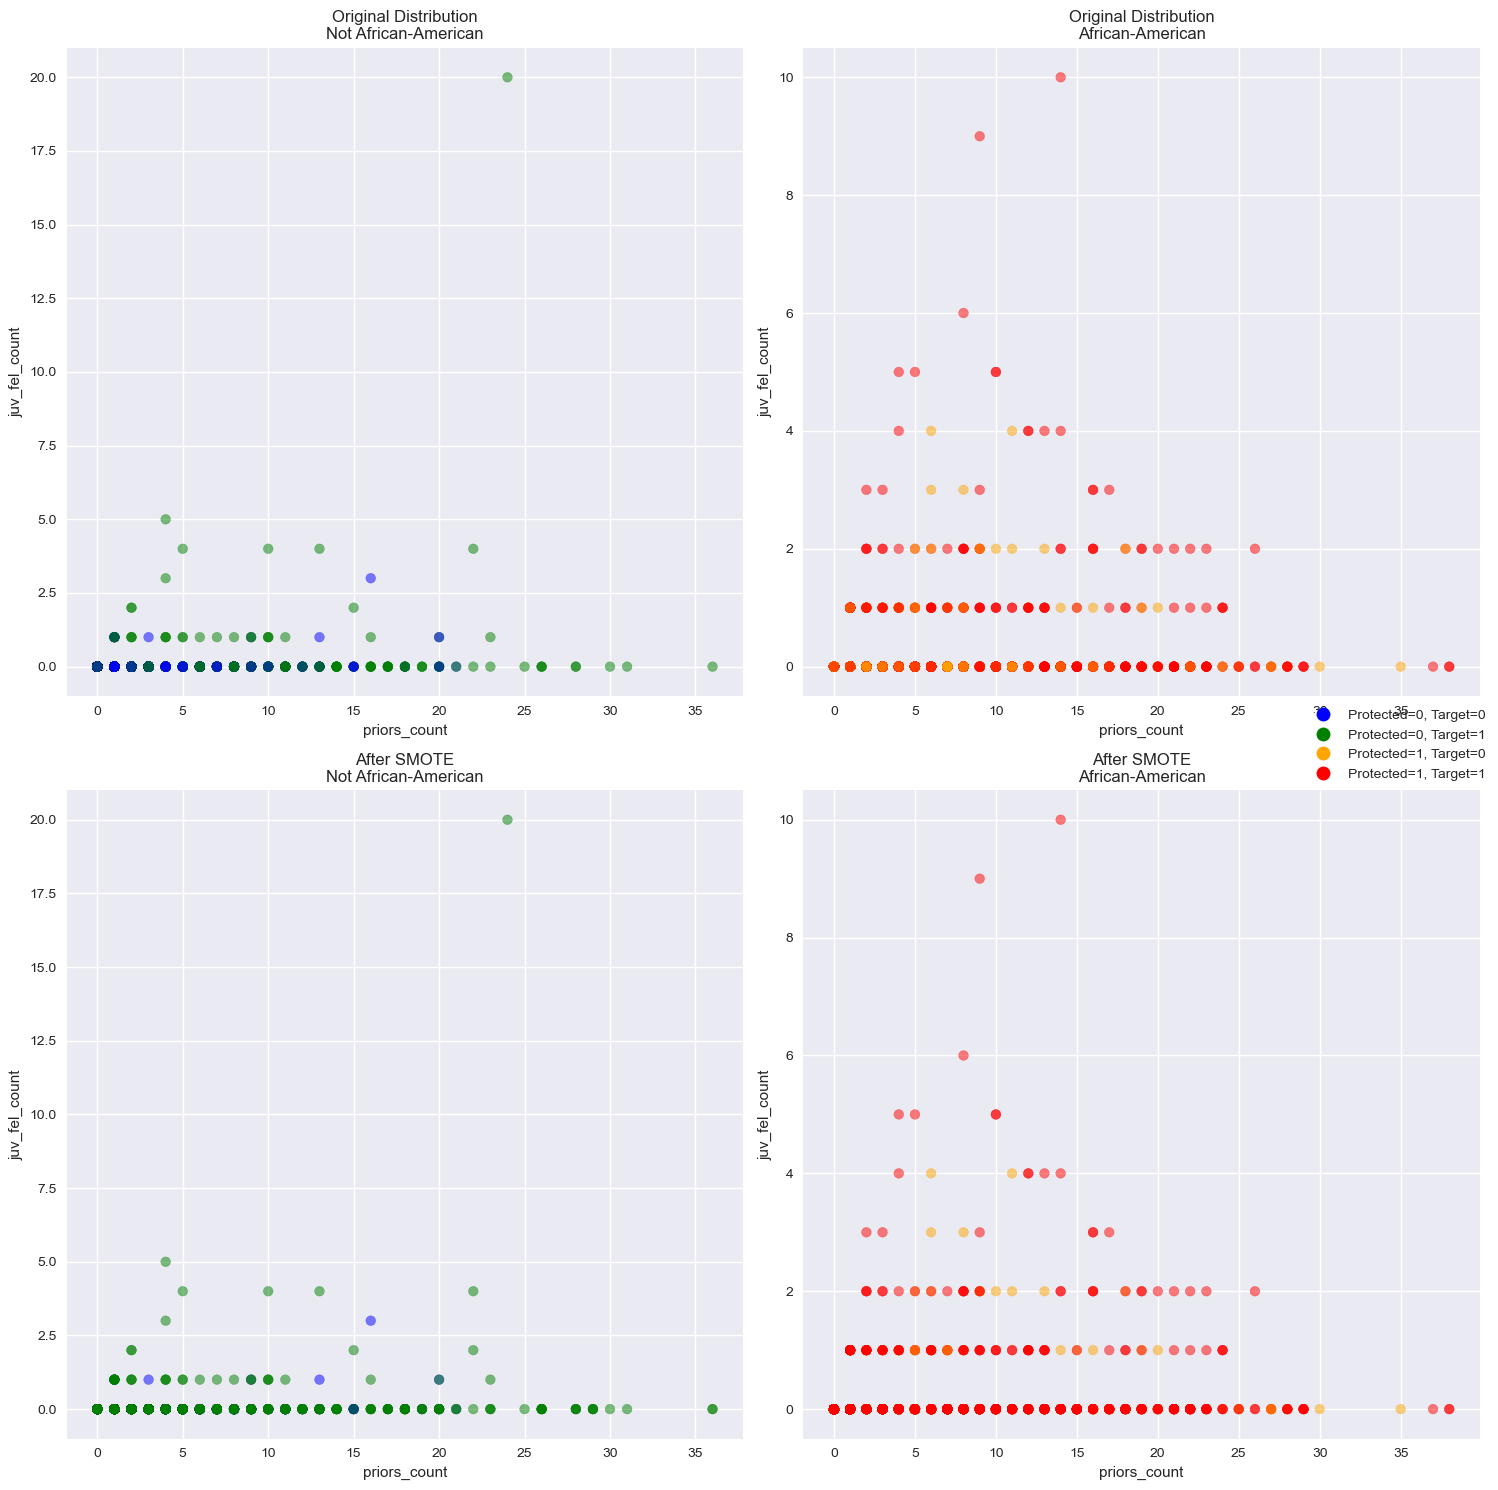

In [88]:
def visualize_smote_scatter(X_train, y_train, X_resampled, y_resampled, protected_attr):
    """
    Visualize data distribution before and after SMOTE using scatter plots
    
    Parameters:
    -----------
    X_train : Original training features
    y_train : Original training labels (0=No recidivism, 1=Yes recidivism)
    X_resampled : Resampled training features
    y_resampled : Resampled training labels
    protected_attr : Name of the protected attribute column (e.g., 'race_African-American' where 0=Not African-American, 1=African-American)
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
    # Create color maps for different combinations
    colors = {
        (0, 0): 'blue',    # Not African-American, No recidivism
        (0, 1): 'green',   # Not African-American, Yes recidivism
        (1, 0): 'orange',  # African-American, No recidivism
        (1, 1): 'red'      # African-American, Yes recidivism
    }
    
    # Select two numerical features for visualization (e.g., priors_count and age)
    feature1 = 'priors_count'
    feature2 = 'juv_fel_count'
    
    # Original Data - Separate scatter plots for each protected group
    # Plot for protected=0 (Not African-American)
    mask_orig_0 = X_train[protected_attr] == 0
    ax1.scatter(X_train[mask_orig_0][feature1], 
               X_train[mask_orig_0][feature2], 
               c=[colors[(0, y)] for y in y_train[mask_orig_0]], 
               alpha=0.5, 
               label=['No recid', 'Yes recid'])
    ax1.set_title('Original Distribution\nNot African-American')
    ax1.set_xlabel(feature1)
    ax1.set_ylabel(feature2)
    
    # Plot for protected=1 (African-American)
    mask_orig_1 = X_train[protected_attr] == 1
    ax2.scatter(X_train[mask_orig_1][feature1], 
               X_train[mask_orig_1][feature2], 
               c=[colors[(1, y)] for y in y_train[mask_orig_1]], 
               alpha=0.5)
    ax2.set_title('Original Distribution\nAfrican-American')
    ax2.set_xlabel(feature1)
    ax2.set_ylabel(feature2)
    
    # Resampled Data - Separate scatter plots for each protected group
    # Plot for protected=0 (Not African-American)
    mask_resampled_0 = X_resampled[protected_attr] == 0
    ax3.scatter(X_resampled[mask_resampled_0][feature1], 
                X_resampled[mask_resampled_0][feature2], 
                c=[colors[(0, y)] for y in y_resampled[mask_resampled_0]], 
                alpha=0.5)
    ax3.set_title('After SMOTE\nNot African-American')
    ax3.set_xlabel(feature1)
    ax3.set_ylabel(feature2)
    
    # Plot for protected=1 (African-American)
    mask_resampled_1 = X_resampled[protected_attr] == 1
    ax4.scatter(X_resampled[mask_resampled_1][feature1], 
                X_resampled[mask_resampled_1][feature2], 
                c=[colors[(1, y)] for y in y_resampled[mask_resampled_1]], 
                alpha=0.5)
    ax4.set_title('After SMOTE\nAfrican-American')
    ax4.set_xlabel(feature1)
    ax4.set_ylabel(feature2)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, label=f'Protected={p}, Target={t}', 
                                 markersize=10)
                      for (p, t), color in colors.items()]
    fig.legend(handles=legend_elements, loc='center right')
    
    # Print distribution summary
    print("\nData Distribution Summary:")
    print("\nOriginal Data:")
    print("Protected Group (0=Not African-American, 1=African-American)")
    print("Target (0=No recidivism, 1=Yes recidivism)")
    print(pd.crosstab(X_train[protected_attr], y_train))
    
    print("\nAfter SMOTE:")
    print(pd.crosstab(X_resampled[protected_attr], y_resampled))
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_smote_scatter(
    X_train, 
    y_train, 
    X_resampled, 
    y_resampled, 
    'race_African-American'
)

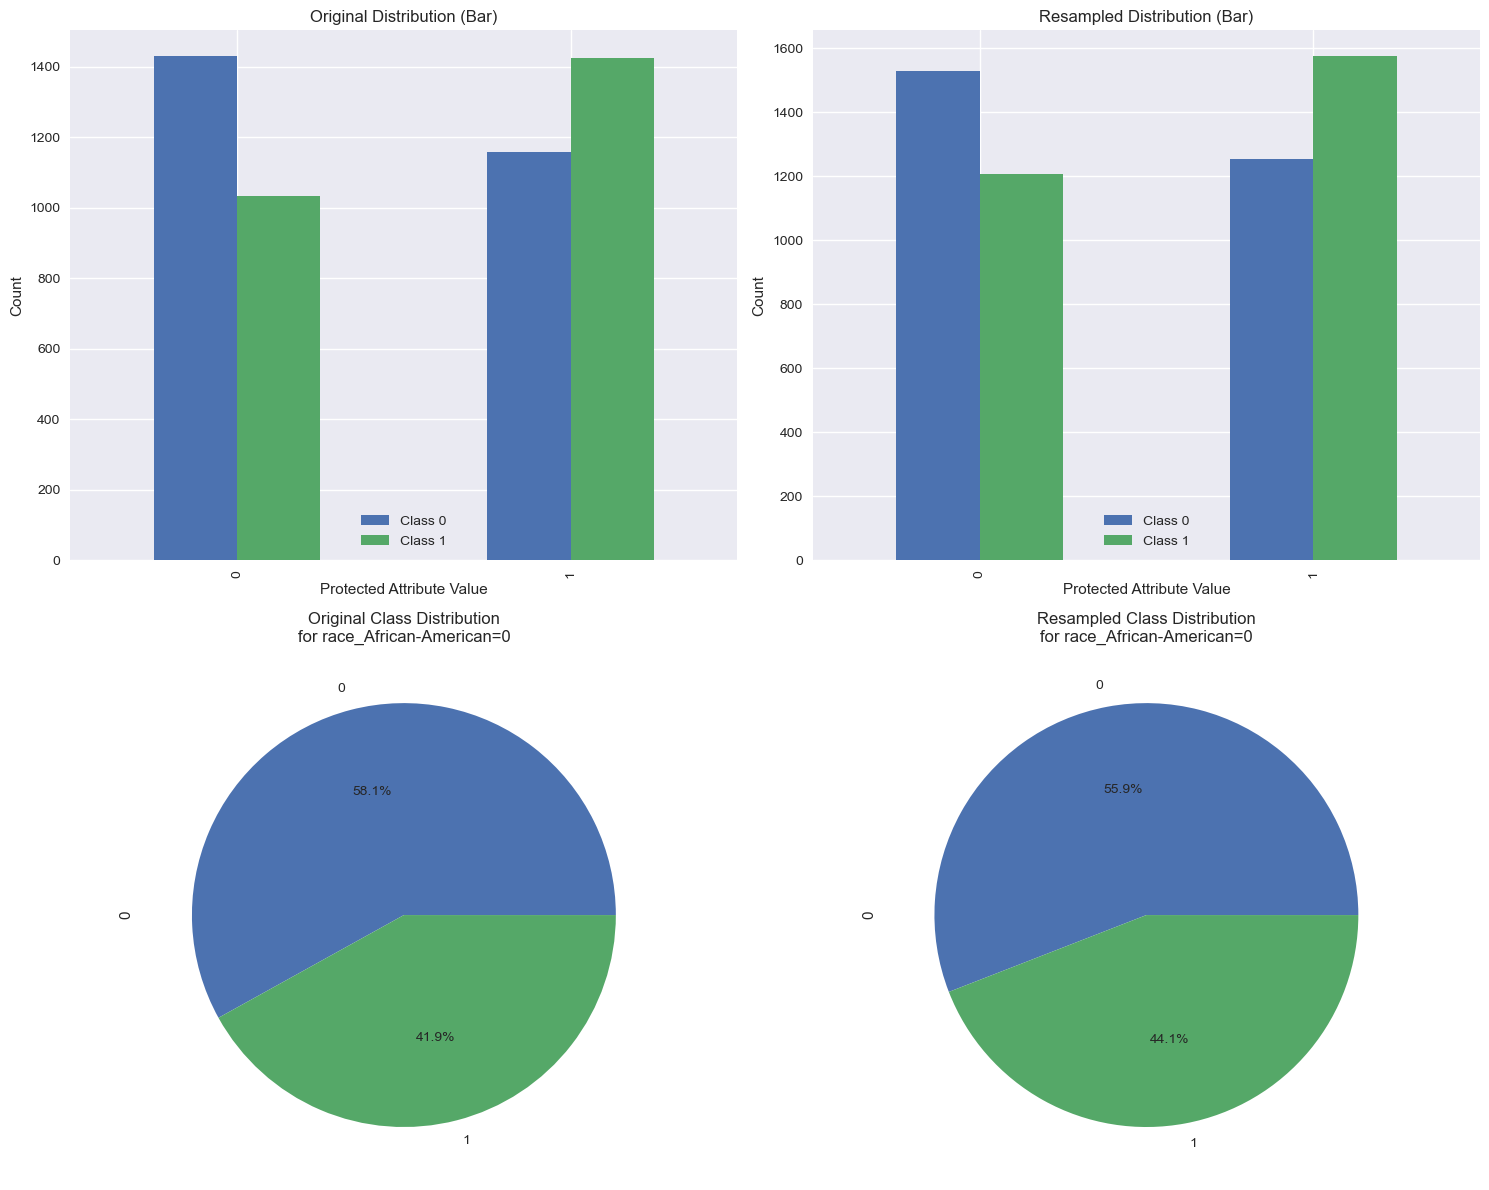


Numerical Distribution Summary:

Original Distribution:
target        0     1
protected            
0          1431  1034
1          1159  1425

Resampled Distribution:
target        0     1
protected            
0          1529  1206
1          1254  1577

Percentage Changes:
target        0      1
protected             
0          6.85  16.63
1          8.20  10.67 %


In [86]:
def visualize_smote_distribution(X_train, y_train, X_resampled, y_resampled, protected_attr):
    """
    Visualize data distribution before and after SMOTE resampling
    
    Parameters:
    -----------
    X_train : Original training features
    y_train : Original training labels
    X_resampled : Resampled training features
    y_resampled : Resampled training labels
    protected_attr : Name of the protected attribute column
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Create DataFrames for easier grouping
    original_df = pd.DataFrame({
        'protected': X_train[protected_attr],
        'target': y_train
    })
    
    resampled_df = pd.DataFrame({
        'protected': X_resampled[protected_attr],
        'target': y_resampled
    })
    
    # Get distribution counts
    orig_dist = original_df.groupby(['protected', 'target']).size().unstack(fill_value=0)
    resamp_dist = resampled_df.groupby(['protected', 'target']).size().unstack(fill_value=0)
    
    # Bar plots
    orig_dist.plot(kind='bar', ax=ax1)
    ax1.set_title('Original Distribution (Bar)')
    ax1.set_xlabel('Protected Attribute Value')
    ax1.set_ylabel('Count')
    ax1.legend(['Class 0', 'Class 1'])
    
    resamp_dist.plot(kind='bar', ax=ax2)
    ax2.set_title('Resampled Distribution (Bar)')
    ax2.set_xlabel('Protected Attribute Value')
    ax2.set_ylabel('Count')
    ax2.legend(['Class 0', 'Class 1'])
    
    # Pie charts
    # For protected attribute = 0
    orig_dist.iloc[0].plot(kind='pie', autopct='%1.1f%%', ax=ax3)
    ax3.set_title(f'Original Class Distribution\nfor {protected_attr}=0')
    
    resamp_dist.iloc[0].plot(kind='pie', autopct='%1.1f%%', ax=ax4)
    ax4.set_title(f'Resampled Class Distribution\nfor {protected_attr}=0')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical summary
    print("\nNumerical Distribution Summary:")
    print("\nOriginal Distribution:")
    print(orig_dist)
    print("\nResampled Distribution:")
    print(resamp_dist)
    
    # Calculate and print percentage changes
    print("\nPercentage Changes:")
    pct_change = ((resamp_dist - orig_dist) / orig_dist * 100).round(2)
    print(pct_change.to_string() + " %")

# Example usage:
visualize_smote_distribution(
    X_train, 
    y_train, 
    X_resampled, 
    y_resampled, 
    'race_African-American'
)

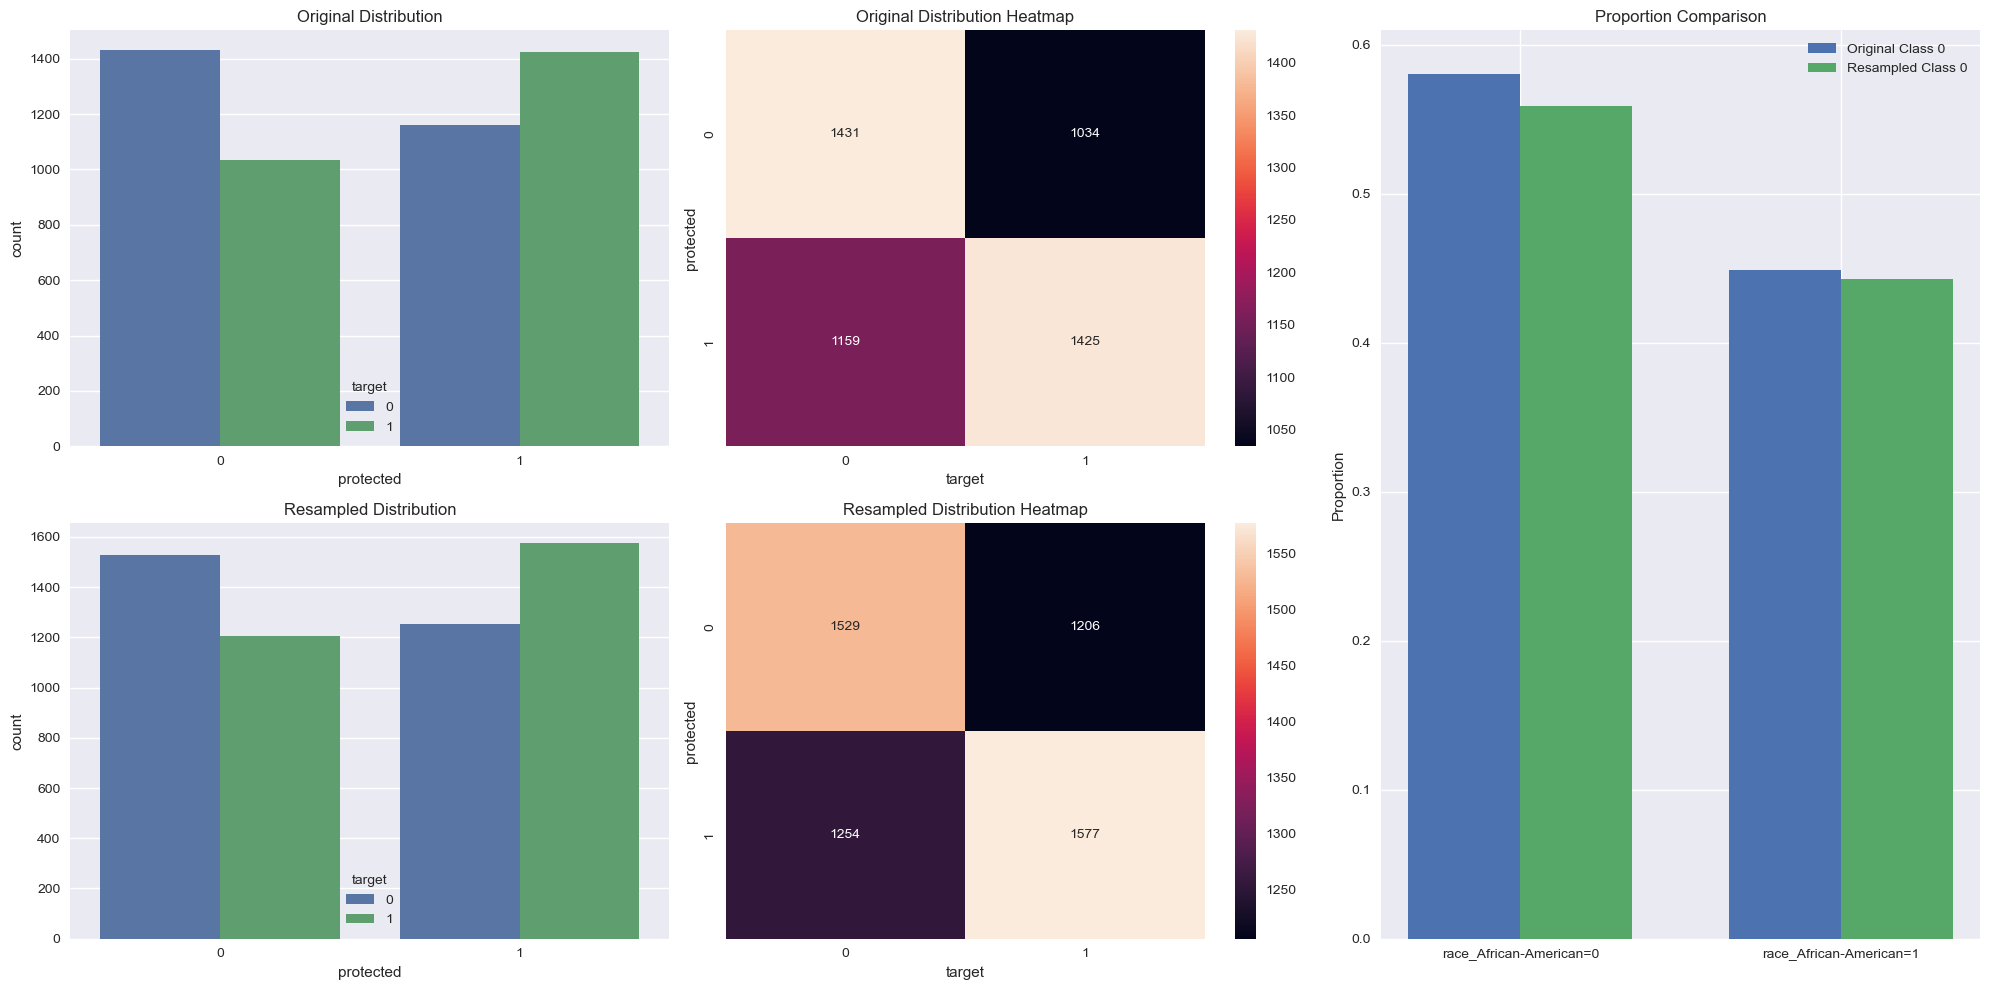

In [87]:
def visualize_detailed_smote_distribution(X_train, y_train, X_resampled, y_resampled, protected_attr):
    """
    Create a detailed visualization of data distribution before and after SMOTE
    """
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(2, 3)
    
    # Bar plot for overall distribution
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Heatmaps for class distribution
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Distribution plots
    ax5 = fig.add_subplot(gs[:, 2])
    
    # Create DataFrames
    original_df = pd.DataFrame({
        'protected': X_train[protected_attr],
        'target': y_train
    })
    
    resampled_df = pd.DataFrame({
        'protected': X_resampled[protected_attr],
        'target': y_resampled
    })
    
    # Overall distribution
    sns.countplot(data=original_df, x='protected', hue='target', ax=ax1)
    ax1.set_title('Original Distribution')
    
    sns.countplot(data=resampled_df, x='protected', hue='target', ax=ax2)
    ax2.set_title('Resampled Distribution')
    
    # Heatmaps
    orig_dist = pd.crosstab(original_df['protected'], original_df['target'])
    resamp_dist = pd.crosstab(resampled_df['protected'], resampled_df['target'])
    
    sns.heatmap(orig_dist, annot=True, fmt='d', ax=ax3)
    ax3.set_title('Original Distribution Heatmap')
    
    sns.heatmap(resamp_dist, annot=True, fmt='d', ax=ax4)
    ax4.set_title('Resampled Distribution Heatmap')
    
    # Distribution comparison
    orig_props = orig_dist.div(orig_dist.sum(axis=1), axis=0)
    resamp_props = resamp_dist.div(resamp_dist.sum(axis=1), axis=0)
    
    # Plot proportions
    x = np.arange(len(orig_props.index))
    width = 0.35
    
    ax5.bar(x - width/2, orig_props[0], width, label='Original Class 0')
    ax5.bar(x + width/2, resamp_props[0], width, label='Resampled Class 0')
    
    ax5.set_xticks(x)
    ax5.set_xticklabels([f'{protected_attr}={val}' for val in orig_props.index])
    ax5.set_ylabel('Proportion')
    ax5.set_title('Proportion Comparison')
    ax5.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_detailed_smote_distribution(
    X_train, 
    y_train, 
    X_resampled, 
    y_resampled, 
    'race_African-American'
)

In [62]:
print(f"\nTraining SMOTE-based XGBoost for sex_Male...")
X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, 'sex_Male')
smote_xgb_sex = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
smote_xgb_sex.fit(X_resampled, y_resampled)
evaluate_model(f"SMOTE XGBoost - sex_Male", smote_xgb_sex, X_test, y_test, protected_groups)


Training SMOTE-based XGBoost for sex_Male...

=== SMOTE XGBoost - sex_Male Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1153
           1       0.65      0.67      0.66      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.68      0.68      0.68      2165


=== Fairness Metrics for SMOTE XGBoost - sex_Male - race ===

Group Fairness Metrics:
Disparate Impact: 1.800
Statistical Parity Difference: 0.279

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.248
Average Odds Difference: 0.230

Privileged Group Metrics:
True Positive Rate: 0.534
False Positive Rate: 0.228
True Negative Rate: 0.772
False Negative Rate: 0.466
Positive Predictive Value: 0.605

Unprivileged Group Metrics:
True Positive Rate: 0.782
False Positive Rate: 0.439
True Negative Rate: 0.561
False Negative Rate: 0.218
Positive Pred

In [63]:
print(f"\nTraining SMOTE-based XGBoost for age_cat_Greater than 45...")
X_resampled, y_resampled, _ = balanced_resample_compas(X_train, y_train, 'age_cat_Greater than 45')
smote_xgb_age = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic'
)
smote_xgb_age.fit(X_resampled, y_resampled)
evaluate_model(f"SMOTE XGBoost - age_cat_Greater than 45", smote_xgb_age, X_test, y_test, protected_groups)



Training SMOTE-based XGBoost for age_cat_Greater than 45...

=== SMOTE XGBoost - age_cat_Greater than 45 Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1153
           1       0.66      0.64      0.65      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.68      0.68      0.68      2165


=== Fairness Metrics for SMOTE XGBoost - age_cat_Greater than 45 - race ===

Group Fairness Metrics:
Disparate Impact: 1.642
Statistical Parity Difference: 0.225

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.196
Average Odds Difference: 0.175

Privileged Group Metrics:
True Positive Rate: 0.538
False Positive Rate: 0.228
True Negative Rate: 0.772
False Negative Rate: 0.462
Positive Predictive Value: 0.606

Unprivileged Group Metrics:
True Positive Rate: 0.733
False Positive Rate: 0.381
True Negative Rate: 0

# 3. ADASYN-based approach for each protected attribute

In [44]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# ADASYN-based approach for each protected attribute
def train_adasyn_model1(X_train, y_train, attr, random_state=42):
    """
    Train XGBoost with ADASYN sampling for a specific protected attribute
    """
    # Create groups based on protected attribute and target
    protected = X_train[attr].values
    groups = pd.DataFrame({
        'protected': protected,
        'target': y_train
    })
    
    # Check class distributions
    print("\nClass distribution before resampling:")
    print(groups.groupby(['protected', 'target']).size())
    
    try:
        # Initialize ADASYN with safer parameters
        adasyn = ADASYN(
            random_state=random_state,
            n_neighbors=min(5, min(groups.groupby(['protected', 'target']).size()) - 1),  # Adjust n_neighbors based on smallest class
            sampling_strategy='minority'  # Only oversample minority class
        )
        
        # Perform ADASYN sampling
        X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
        
    except ValueError as e:
        print(f"ADASYN failed: {e}")
        print("Falling back to original data...")
        X_resampled, y_resampled = X_train, y_train
    
    # Train XGBoost on resampled (or original) data
    adasyn_xgb = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200,
        objective='binary:logistic'
    )
    adasyn_xgb.fit(X_resampled, y_resampled)
    
    # Print final distribution
    print("\nClass distribution after resampling:")
    print(pd.DataFrame({
        'protected': X_resampled[attr].values,
        'target': y_resampled
    }).groupby(['protected', 'target']).size())
    
    return adasyn_xgb, X_resampled, y_resampled


def train_adasyn_model(X_train, y_train, attr, random_state=42):
    """
    Train XGBoost with ADASYN sampling for a specific protected attribute
    """
    # Create combined labels that consider both protected attribute and target
    protected = X_train[attr].values
    combined_labels = protected * 2 + y_train  # Creates 4 classes: (0,0), (0,1), (1,0), (1,1)
    
    print("\nOriginal distribution:")
    print("Protected attribute distribution:")
    print(pd.Series(protected).value_counts())
    print("\nTarget distribution within protected groups:")
    print(pd.DataFrame({'protected': protected, 'target': y_train})
          .groupby(['protected', 'target']).size().unstack(fill_value=0))
    
    try:
        # Initialize ADASYN with careful parameter tuning
        adasyn = ADASYN(
            sampling_strategy='minority',
            random_state=random_state,
            n_neighbors=min(5, pd.Series(combined_labels).value_counts().min() - 1)
        )
        
        # Perform ADASYN sampling on the combined labels
        X_resampled, combined_labels_resampled = adasyn.fit_resample(X_train, combined_labels)
        
        # Convert back to separate protected attribute and target
        protected_resampled = (combined_labels_resampled >= 2).astype(int)
        y_resampled = combined_labels_resampled % 2
        
        print("\nResampled distribution:")
        print("Protected attribute distribution:")
        print(pd.Series(protected_resampled).value_counts())
        print("\nTarget distribution within protected groups:")
        print(pd.DataFrame({'protected': protected_resampled, 'target': y_resampled})
              .groupby(['protected', 'target']).size().unstack(fill_value=0))
        
    except ValueError as e:
        print(f"\nADASYN failed: {e}")
        print("Falling back to original data...")
        X_resampled, y_resampled, protected_resampled = X_train, y_train, protected
    
    # Train XGBoost on resampled data
    adasyn_xgb = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=200,
        objective='binary:logistic',
        random_state=random_state
    )
    adasyn_xgb.fit(X_resampled, y_resampled)
    
    return adasyn_xgb, X_resampled, y_resampled

In [45]:
# # Example usage for each protected attribute
# for attr in ['race_African-American', 'sex_Male', 'age_cat_Greater than 45']:
#     print(f"\nTraining ADASYN-based XGBoost for {attr}...")
#     adasyn_xgb, X_resampled, y_resampled = train_adasyn_model(X_train, y_train, attr)
#     evaluate_model(f"ADASYN XGBoost - {attr}", adasyn_xgb, X_test, y_test, protected_groups)

In [46]:
# 1. ADASYN for race
print("\nTraining ADASYN-based XGBoost for race_African-American...")
adasyn_xgb_race, X_resampled_race, y_resampled_race = train_adasyn_model(X_train, y_train, 'race_African-American')
evaluate_model("ADASYN XGBoost - race", adasyn_xgb_race, X_test, y_test, protected_groups)


Training ADASYN-based XGBoost for race_African-American...

Original distribution:
Protected attribute distribution:
1    2584
0    2465
dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1431  1034
1          1159  1425

Resampled distribution:
Protected attribute distribution:
0    2738
1    2584
Name: is_recid, dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1431  1307
1          1159  1425

=== ADASYN XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1153
           1       0.65      0.68      0.67      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.68      0.68      0.68      2165


=== Fairness Metrics for ADASYN XGBoost - race - race ===

Group Fairness Metr

In [47]:
# 2. ADASYN for sex
print("\nTraining ADASYN-based XGBoost for sex_Male...")
adasyn_xgb_sex, X_resampled_sex, y_resampled_sex = train_adasyn_model(X_train, y_train, 'sex_Male')
evaluate_model("ADASYN XGBoost - sex", adasyn_xgb_sex, X_test, y_test, protected_groups)


Training ADASYN-based XGBoost for sex_Male...

Original distribution:
Protected attribute distribution:
1    4051
0     998
dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0           613   385
1          1977  2074

Resampled distribution:
Protected attribute distribution:
1    4051
0    2767
Name: is_recid, dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0           613  2154
1          1977  2074

=== ADASYN XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.53      0.60      1153
           1       0.58      0.75      0.66      1012

    accuracy                           0.63      2165
   macro avg       0.65      0.64      0.63      2165
weighted avg       0.65      0.63      0.63      2165


=== Fairness Metrics for ADASYN XGBoost - sex - race ===

Group Fairness Metrics:
Disparate 

In [48]:
# 3. ADASYN for age
print("\nTraining ADASYN-based XGBoost for age_cat_Greater than 45...")
adasyn_xgb_age, X_resampled_age, y_resampled_age = train_adasyn_model(X_train, y_train, 'age_cat_Greater than 45')
evaluate_model("ADASYN XGBoost - age", adasyn_xgb_age, X_test, y_test, protected_groups)


Training ADASYN-based XGBoost for age_cat_Greater than 45...

Original distribution:
Protected attribute distribution:
0    3929
1    1120
dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1868  2061
1           722   398

Resampled distribution:
Protected attribute distribution:
0    3929
1    2721
Name: is_recid, dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1868  2061
1           722  1999

=== ADASYN XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.48      0.56      1153
           1       0.56      0.74      0.64      1012

    accuracy                           0.60      2165
   macro avg       0.62      0.61      0.60      2165
weighted avg       0.62      0.60      0.60      2165


=== Fairness Metrics for ADASYN XGBoost - age - race ===

Group Fairness Metr

# 4. Fair XGBoost for each protected attribute

In [49]:
# 3. Fair XGBoost for each protected attribute
# protected_attributes = {
#     'race': X_train['race_African-American'].values,
#     'sex': X_train['sex_Male'].values,
#     'age': X_train['age_cat_Greater than 45'].values
# }

# for attr, values in protected_attributes.items():
#     print(f"\nTraining Fair XGBoost for {attr}...")
#     fair_xgb = CompasImpactParityXGBoost(fairness_weight=0.3, impact_threshold=0.8)
#     fair_xgb.fit(X_train, y_train, values)
#     evaluate_model(f"Fair XGBoost - {attr}", fair_xgb, X_test, y_test, protected_groups)

In [50]:
# Fair XGBoost for race
print("\nTraining Fair XGBoost for race...")
fair_xgb_race = CompasImpactParityXGBoost(fairness_weight=0.1, impact_threshold=0.9)
fair_xgb_race.fit(X_train, y_train, X_train['race_African-American'].values)
evaluate_model("Fair XGBoost - race", fair_xgb_race, X_test, y_test, protected_groups)


Training Fair XGBoost for race...

=== Fair XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1153
           1       0.68      0.65      0.66      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


=== Fairness Metrics for Fair XGBoost - race - race ===

Group Fairness Metrics:
Disparate Impact: 1.823
Statistical Parity Difference: 0.265

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.242
Average Odds Difference: 0.213

Privileged Group Metrics:
True Positive Rate: 0.514
False Positive Rate: 0.196
True Negative Rate: 0.804
False Negative Rate: 0.486
Positive Predictive Value: 0.630

Unprivileged Group Metrics:
True Positive Rate: 0.756
False Positive Rate: 0.379
True Negative Rate: 0.621
False Negative Rate: 0.244
Positive Predictive Value: 0.709



c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [51]:
# Fair XGBoost for sex
print("\nTraining Fair XGBoost for sex...")
fair_xgb_sex = CompasImpactParityXGBoost(fairness_weight=0.1, impact_threshold=0.8)
fair_xgb_sex.fit(X_train, y_train, X_train['sex_Male'].values)
evaluate_model("Fair XGBoost - sex", fair_xgb_sex, X_test, y_test, protected_groups)


Training Fair XGBoost for sex...

=== Fair XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1153
           1       0.68      0.65      0.66      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


=== Fairness Metrics for Fair XGBoost - sex - race ===

Group Fairness Metrics:
Disparate Impact: 1.829
Statistical Parity Difference: 0.267

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.244
Average Odds Difference: 0.214

Privileged Group Metrics:
True Positive Rate: 0.514
False Positive Rate: 0.196
True Negative Rate: 0.804
False Negative Rate: 0.486
Positive Predictive Value: 0.630

Unprivileged Group Metrics:
True Positive Rate: 0.758
False Positive Rate: 0.381
True Negative Rate: 0.619
False Negative Rate: 0.242
Positive Predictive Value: 0.708

===

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [52]:
X_train.head()
X_train.shape
X_train.columns
# X_train.info()
# X_train.describe()
X_train['age_cat_Greater than 45'].value_counts()


0    3929
1    1120
Name: age_cat_Greater than 45, dtype: int64

In [53]:
# Fair XGBoost for age
print("\nTraining Fair XGBoost for age...")
# print(X_train['age_cat_Greater than 45'].values)
fair_xgb_age = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.8)
fair_xgb_age.fit(X_train, y_train, X_train['age_cat_Greater than 45'].values)
evaluate_model("Fair XGBoost - age", fair_xgb_age, X_test, y_test, protected_groups)



Training Fair XGBoost for age...
Impact Ratio: 3.281, Penalty: 0.203

=== Fair XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1153
           1       0.70      0.61      0.65      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


=== Fairness Metrics for Fair XGBoost - age - race ===

Group Fairness Metrics:
Disparate Impact: 1.848
Statistical Parity Difference: 0.246

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.232
Average Odds Difference: 0.194

Privileged Group Metrics:
True Positive Rate: 0.479
False Positive Rate: 0.167
True Negative Rate: 0.833
False Negative Rate: 0.521
Positive Predictive Value: 0.651

Unprivileged Group Metrics:
True Positive Rate: 0.712
False Positive Rate: 0.323
True Negative Rate: 0.677
False Negative Rate: 0.288
P

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


# 5. Combined SMOTE + Fair XGBoost for each protected attribute

In [54]:
# 4. Combined SMOTE + Fair XGBoost for each protected attribute
# for attr, values in protected_attributes.items():
#     print(f"\nTraining Combined SMOTE + Fair XGBoost for {attr}...")
#     attr_name = f"{'race_African-American' if attr == 'race' else 'sex_Male' if attr == 'sex' else 'age_cat_Greater than 45'}"
#     X_resampled, y_resampled, protected_resampled = balanced_resample_compas(X_train, y_train, attr_name)
    
#     combined_xgb = CompasImpactParityXGBoost(fairness_weight=0.3, impact_threshold=0.8)
#     combined_xgb.fit(X_resampled, y_resampled, protected_resampled)
#     evaluate_model(f"Combined SMOTE + Fair XGBoost - {attr}", combined_xgb, X_test, y_test, protected_groups)

In [55]:
print("\nTraining Combined SMOTE + Fair XGBoost for race...")
X_resampled_race, y_resampled_race, protected_resampled_race = balanced_resample_compas(X_train, y_train, 'race_African-American')
combined_xgb_race = CompasImpactParityXGBoost(fairness_weight=0.3, impact_threshold=0.8)
combined_xgb_race.fit(X_resampled_race, y_resampled_race, protected_resampled_race)
evaluate_model("Combined SMOTE + Fair XGBoost - race", combined_xgb_race, X_test, y_test, protected_groups)


Training Combined SMOTE + Fair XGBoost for race...


c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



=== Combined SMOTE + Fair XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1153
           1       0.65      0.67      0.66      1012

    accuracy                           0.67      2165
   macro avg       0.67      0.67      0.67      2165
weighted avg       0.68      0.67      0.68      2165


=== Fairness Metrics for Combined SMOTE + Fair XGBoost - race - race ===

Group Fairness Metrics:
Disparate Impact: 1.100
Statistical Parity Difference: 0.047

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.025
Average Odds Difference: -0.006

Privileged Group Metrics:
True Positive Rate: 0.661
False Positive Rate: 0.342
True Negative Rate: 0.658
False Negative Rate: 0.339
Positive Predictive Value: 0.558

Unprivileged Group Metrics:
True Positive Rate: 0.686
False Positive Rate: 0.305
True Negative Rate: 0.695
False Negative Rate: 0.314
Positive Predictive Value: 0.733



In [56]:
# Combined SMOTE + Fair XGBoost for sex
print("\nTraining Combined SMOTE + Fair XGBoost for sex...")
X_resampled_sex, y_resampled_sex, protected_resampled_sex = balanced_resample_compas(X_train, y_train, 'sex_Male')
combined_xgb_sex = CompasImpactParityXGBoost(fairness_weight=0.1, impact_threshold=0.8)
combined_xgb_sex.fit(X_resampled_sex, y_resampled_sex, protected_resampled_sex)
evaluate_model("Combined SMOTE + Fair XGBoost - sex", combined_xgb_sex, X_test, y_test, protected_groups)


Training Combined SMOTE + Fair XGBoost for sex...

=== Combined SMOTE + Fair XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1153
           1       0.65      0.67      0.66      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.68      0.68      0.68      2165


=== Fairness Metrics for Combined SMOTE + Fair XGBoost - sex - race ===

Group Fairness Metrics:
Disparate Impact: 1.516
Statistical Parity Difference: 0.198

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.171
Average Odds Difference: 0.148

Privileged Group Metrics:
True Positive Rate: 0.572
False Positive Rate: 0.261
True Negative Rate: 0.739
False Negative Rate: 0.428
Positive Predictive Value: 0.588

Unprivileged Group Metrics:
True Positive Rate: 0.743
False Positive Rate: 0.385
True Negative Rate: 0.615
False Negativ

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [57]:
# Combined SMOTE + Fair XGBoost for age
print("\nTraining Combined SMOTE + Fair XGBoost for age...")
X_resampled_age, y_resampled_age, protected_resampled_age = balanced_resample_compas(X_train, y_train, 'age_cat_Greater than 45')
combined_xgb_age = CompasImpactParityXGBoost(fairness_weight=0.3, impact_threshold=0.8)
combined_xgb_age.fit(X_resampled_age, y_resampled_age, protected_resampled_age)
evaluate_model("Combined SMOTE + Fair XGBoost - age", combined_xgb_age, X_test, y_test, protected_groups)


Training Combined SMOTE + Fair XGBoost for age...

=== Combined SMOTE + Fair XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1153
           1       0.66      0.64      0.65      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.67      0.67      2165
weighted avg       0.68      0.68      0.68      2165


=== Fairness Metrics for Combined SMOTE + Fair XGBoost - age - race ===

Group Fairness Metrics:
Disparate Impact: 1.626
Statistical Parity Difference: 0.221

Equal Opportunity Metrics:
Equal Opportunity Difference: 0.189
Average Odds Difference: 0.172

Privileged Group Metrics:
True Positive Rate: 0.541
False Positive Rate: 0.232
True Negative Rate: 0.768
False Negative Rate: 0.459
Positive Predictive Value: 0.603

Unprivileged Group Metrics:
True Positive Rate: 0.730
False Positive Rate: 0.387
True Negative Rate: 0.613
False Negativ

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


# 6. Combined ADASYN + Fair XGBoost for each protected attribute


In [67]:
# Combined ADASYN + Fair XGBoost for race
print("\nTraining Combined ADASYN + Fair XGBoost for race...")
# First apply ADASYN
adasyn_xgb_race, X_resampled_race, y_resampled_race = train_adasyn_model(X_train, y_train, 'race_African-American')
protected_resampled_race = X_resampled_race['race_African-American'].values

# Then apply Fair XGBoost on resampled data
combined_adasyn_fair_xgb_race = CompasImpactParityXGBoost(fairness_weight=0.3, impact_threshold=0.8)
combined_adasyn_fair_xgb_race.fit(X_resampled_race, y_resampled_race, protected_resampled_race)
evaluate_model("Combined ADASYN + Fair XGBoost - race", combined_adasyn_fair_xgb_race, X_test, y_test, protected_groups)


Training Combined ADASYN + Fair XGBoost for race...

Original distribution:
Protected attribute distribution:
1    2584
0    2465
dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1431  1034
1          1159  1425

Resampled distribution:
Protected attribute distribution:
0    2738
1    2584
Name: is_recid, dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1431  1307
1          1159  1425

=== Combined ADASYN + Fair XGBoost - race Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1153
           1       0.66      0.68      0.67      1012

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.68      0.68      0.68      2165


=== Fairness Metrics for Combined ADASYN + Fair XGBoost - race - race

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [68]:
# Combined ADASYN + Fair XGBoost for sex
print("\nTraining Combined ADASYN + Fair XGBoost for sex...")
# First apply ADASYN
adasyn_xgb_sex, X_resampled_sex, y_resampled_sex = train_adasyn_model(X_train, y_train, 'sex_Male')
protected_resampled_sex = X_resampled_sex['sex_Male'].values

# Then apply Fair XGBoost on resampled data
combined_adasyn_fair_xgb_sex = CompasImpactParityXGBoost(fairness_weight=0.2, impact_threshold=0.8)
combined_adasyn_fair_xgb_sex.fit(X_resampled_sex, y_resampled_sex, protected_resampled_sex)
evaluate_model("Combined ADASYN + Fair XGBoost - sex", combined_adasyn_fair_xgb_sex, X_test, y_test, protected_groups)



Training Combined ADASYN + Fair XGBoost for sex...

Original distribution:
Protected attribute distribution:
1    4051
0     998
dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0           613   385
1          1977  2074

Resampled distribution:
Protected attribute distribution:
1    4051
0    2767
Name: is_recid, dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0           613  2154
1          1977  2074

=== Combined ADASYN + Fair XGBoost - sex Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62      1153
           1       0.59      0.72      0.65      1012

    accuracy                           0.64      2165
   macro avg       0.64      0.64      0.64      2165
weighted avg       0.65      0.64      0.64      2165


=== Fairness Metrics for Combined ADASYN + Fair XGBoost - sex - race ==

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:56:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:

# Combined ADASYN + Fair XGBoost for age
print("\nTraining Combined ADASYN + Fair XGBoost for age...")
# First apply ADASYN
adasyn_xgb_age, X_resampled_age, y_resampled_age = train_adasyn_model(X_train, y_train, 'age_cat_Greater than 45')
protected_resampled_age = X_resampled_age['age_cat_Greater than 45'].values

# Then apply Fair XGBoost on resampled data
combined_adasyn_fair_xgb_age = CompasImpactParityXGBoost(fairness_weight=0.1, impact_threshold=0.8)
combined_adasyn_fair_xgb_age.fit(X_resampled_age, y_resampled_age, protected_resampled_age)
evaluate_model("Combined ADASYN + Fair XGBoost - age", combined_adasyn_fair_xgb_age, X_test, y_test, protected_groups)


Training Combined ADASYN + Fair XGBoost for age...

Original distribution:
Protected attribute distribution:
0    3929
1    1120
dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1868  2061
1           722   398

Resampled distribution:
Protected attribute distribution:
0    3929
1    2721
Name: is_recid, dtype: int64

Target distribution within protected groups:
target        0     1
protected            
0          1868  2061
1           722  1999
Impact Ratio: 0.487, Penalty: 0.051

=== Combined ADASYN + Fair XGBoost - age Performance ===

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56      1153
           1       0.55      0.73      0.63      1012

    accuracy                           0.60      2165
   macro avg       0.61      0.61      0.60      2165
weighted avg       0.62      0.60      0.59      2165


=== Fairness Metrics for Combined A

c:\Users\fsd_n\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:56:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


# Visualization


## ROC curve

In [64]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(models_dict, X_test, y_test):
    """
    Plot ROC curves for multiple models
    
    Parameters:
    models_dict: Dictionary of model names and fitted model objects
    X_test: Test features
    y_test: Test labels
    """
    plt.figure(figsize=(10, 8))
    
    for name, model in models_dict.items():
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            # For models that don't have predict_proba
            y_pred_proba = model.predict(X_test)
            
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

# models_dict = {
#     'Regular XGBoost': regular_xgb,
#     'SMOTE XGBoost - Race': smote_xgb_race,
#     'SMOTE XGBoost - Sex': smote_xgb_sex,
#     'SMOTE XGBoost - Age': smote_xgb_age,
#     'ADASYN XGBoost - Race': adasyn_xgb_race,
#     'ADASYN XGBoost - Sex': adasyn_xgb_sex,
#     'ADASYN XGBoost - Age': adasyn_xgb_age,
#     'Fair XGBoost - Race': fair_xgb_race,
#     'Fair XGBoost - Sex': fair_xgb_sex,
#     'Fair XGBoost - Age': fair_xgb_age,
#     'Combined SMOTE + Fair XGBoost - Race': combined_xgb_race,
#     'Combined SMOTE + Fair XGBoost - Sex': combined_xgb_sex,
#     'Combined SMOTE + Fair XGBoost - Age': combined_xgb_age
# }

# plot_roc_curves(models_dict, X_test, y_test)

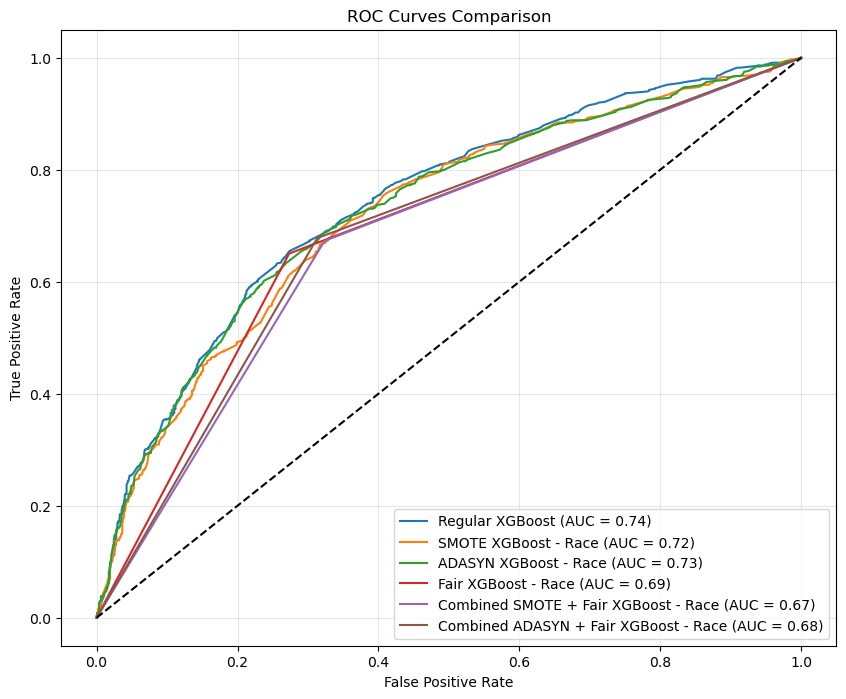

In [72]:
# Usage example
models_dict = {
    'Regular XGBoost': regular_xgb,
    'SMOTE XGBoost - Race': smote_xgb_race,
    # 'SMOTE XGBoost - Sex': smote_xgb_sex,
    # 'SMOTE XGBoost - Age': smote_xgb_age,
    'ADASYN XGBoost - Race': adasyn_xgb_race,
    # 'ADASYN XGBoost - Sex': adasyn_xgb_sex,
    # 'ADASYN XGBoost - Age': adasyn_xgb_age,
    'Fair XGBoost - Race': fair_xgb_race,
    # 'Fair XGBoost - Sex': fair_xgb_sex,
    # 'Fair XGBoost - Age': fair_xgb_age,
    'Combined SMOTE + Fair XGBoost - Race': combined_xgb_race,
    # 'Combined SMOTE + Fair XGBoost - Sex': combined_xgb_sex,
    # 'Combined SMOTE + Fair XGBoost - Age': combined_xgb_age,
    'Combined ADASYN + Fair XGBoost - Race': combined_adasyn_fair_xgb_race,
    # 'Combined ADASYN + Fair XGBoost - Sex': combined_adasyn_fair_xgb_sex,
    # 'Combined ADASYN + Fair XGBoost - Age': combined_adasyn_fair_xgb_age
}

plot_roc_curves(models_dict, X_test, y_test)

## Visualize Disparate Impact

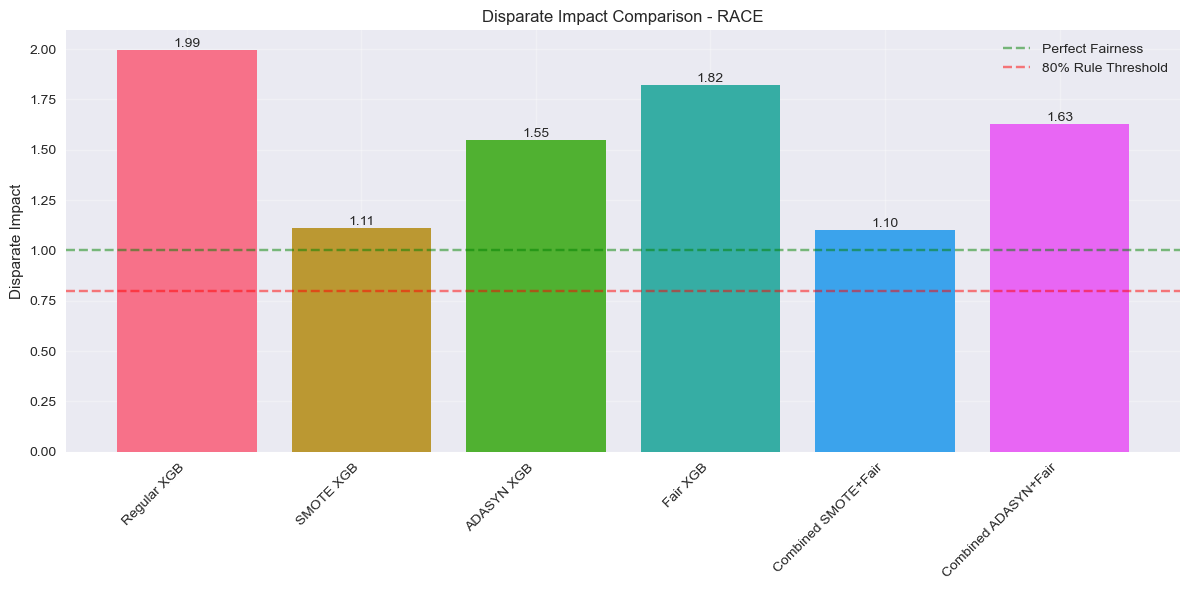

In [77]:
# Plot for Race
plt.figure(figsize=(12, 6))
models_dict_race = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB': smote_xgb_race,
    'ADASYN XGB': adasyn_xgb_race,
    'Fair XGB': fair_xgb_race,
    'Combined SMOTE+Fair': combined_xgb_race,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_race
}

disparate_impacts = []
method_names = []

for method_name, model in models_dict_race.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['race']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['race']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['race']['unprivileged'],
        privileged_groups=protected_groups['race']['privileged']
    )
    
    disparate_impacts.append(metrics.disparate_impact())
    method_names.append(method_name)

bars = plt.bar(range(len(method_names)), disparate_impacts, color=sns.color_palette("husl", len(models_dict_race)))
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Fairness')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% Rule Threshold')

plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.title('Disparate Impact Comparison - RACE')
plt.ylabel('Disparate Impact')
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

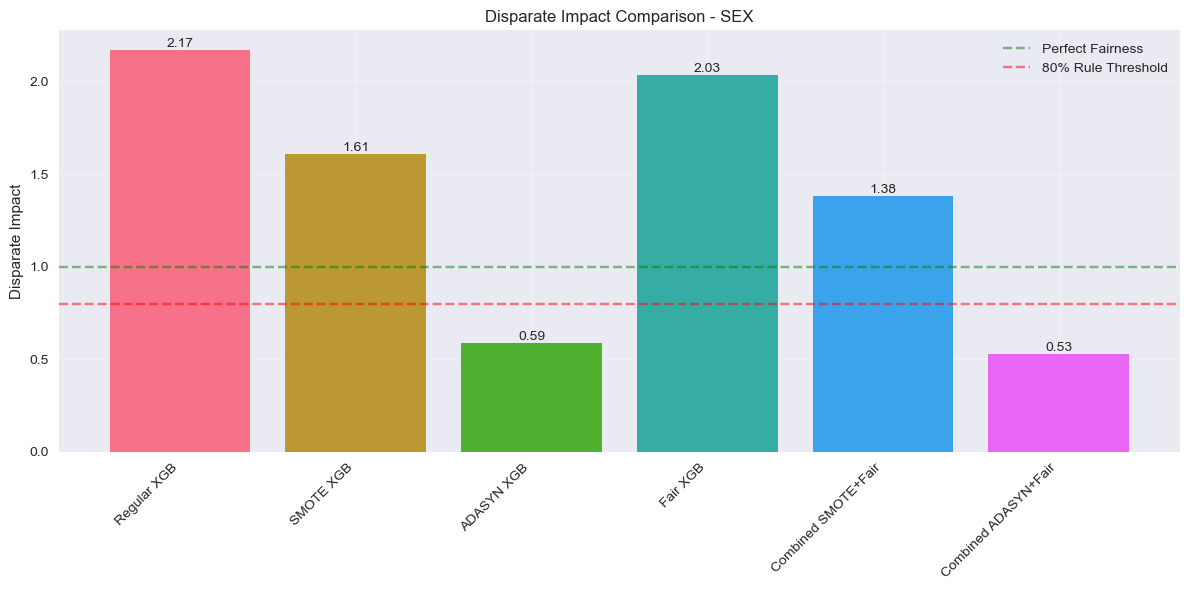

In [78]:
# Plot for Sex
plt.figure(figsize=(12, 6))
models_dict_sex = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB': smote_xgb_sex,
    'ADASYN XGB': adasyn_xgb_sex,
    'Fair XGB': fair_xgb_sex,
    'Combined SMOTE+Fair': combined_xgb_sex,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_sex
}

disparate_impacts = []
method_names = []

for method_name, model in models_dict_sex.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['sex']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['sex']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['sex']['unprivileged'],
        privileged_groups=protected_groups['sex']['privileged']
    )
    
    disparate_impacts.append(metrics.disparate_impact())
    method_names.append(method_name)

bars = plt.bar(range(len(method_names)), disparate_impacts, color=sns.color_palette("husl", len(models_dict_sex)))
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Fairness')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% Rule Threshold')

plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.title('Disparate Impact Comparison - SEX')
plt.ylabel('Disparate Impact')
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

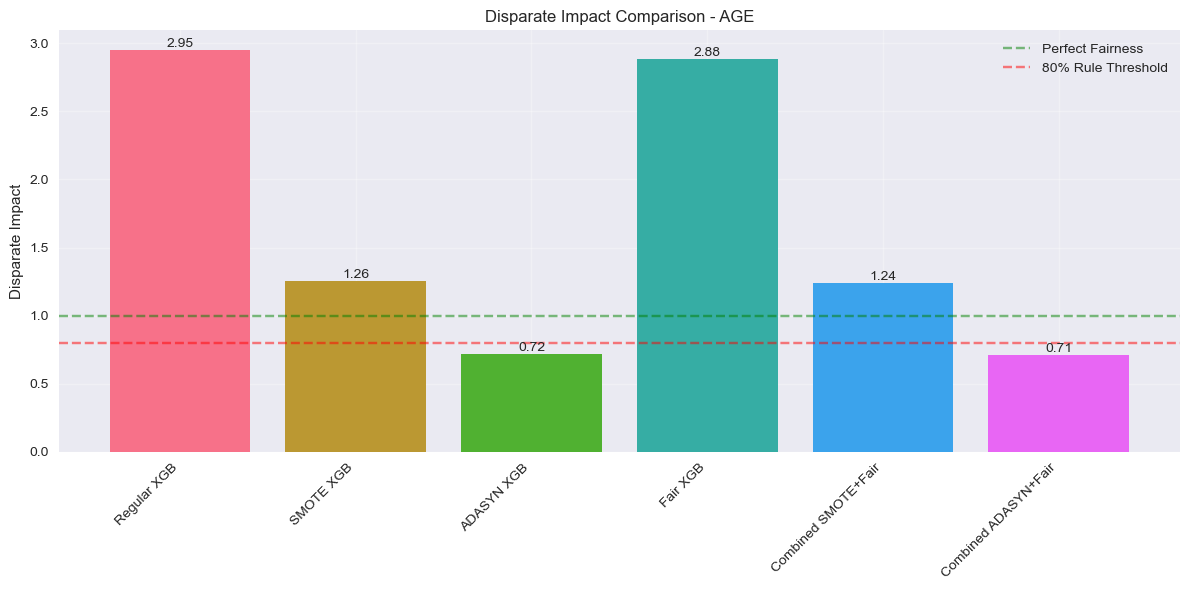

In [79]:
# Plot for Age
plt.figure(figsize=(12, 6))
models_dict_age = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB': smote_xgb_age,
    'ADASYN XGB': adasyn_xgb_age,
    'Fair XGB': fair_xgb_age,
    'Combined SMOTE+Fair': combined_xgb_age,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_age
}

disparate_impacts = []
method_names = []

for method_name, model in models_dict_age.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['age']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['age']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['age']['unprivileged'],
        privileged_groups=protected_groups['age']['privileged']
    )
    
    disparate_impacts.append(metrics.disparate_impact())
    method_names.append(method_name)

bars = plt.bar(range(len(method_names)), disparate_impacts, color=sns.color_palette("husl", len(models_dict_age)))
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Fairness')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% Rule Threshold')

plt.xticks(range(len(method_names)), method_names, rotation=45, ha='right')
plt.title('Disparate Impact Comparison - AGE')
plt.ylabel('Disparate Impact')
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

## Visualize FPR, FNR

<Figure size 1500x600 with 0 Axes>

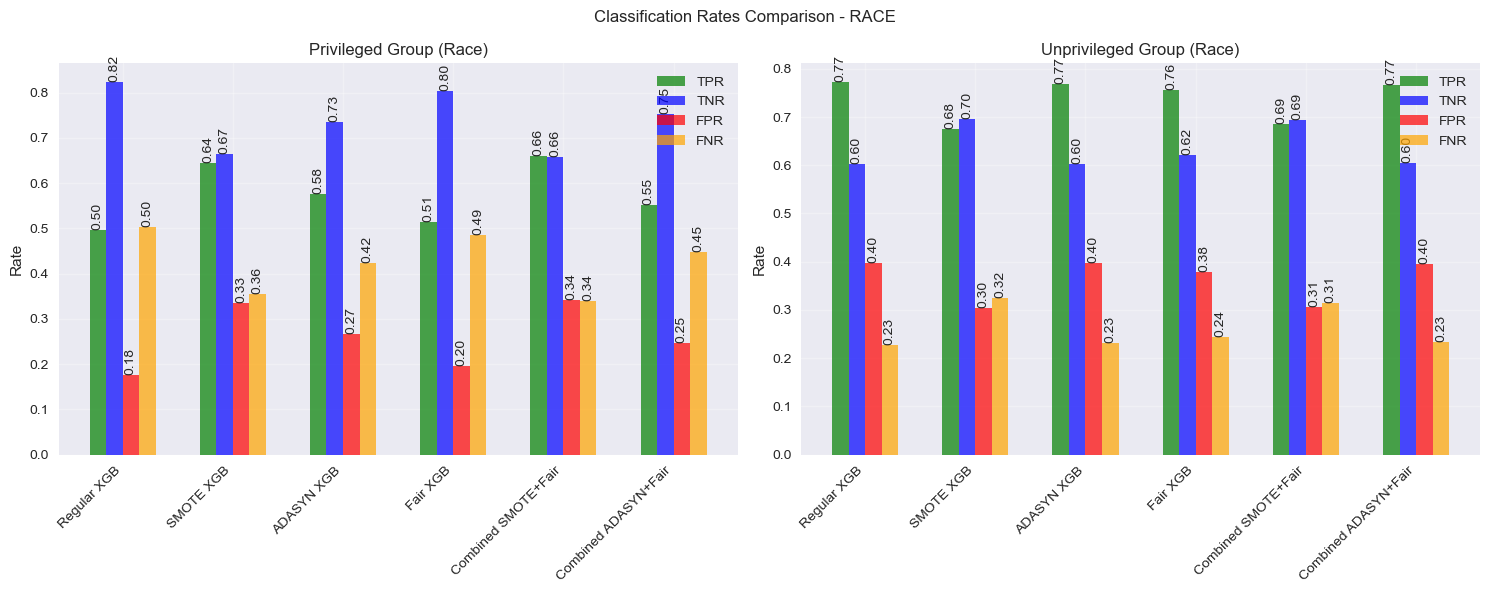

In [81]:
# Plot for Race
plt.figure(figsize=(15, 6))
models_dict_race = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB': smote_xgb_race,
    'ADASYN XGB': adasyn_xgb_race,
    'Fair XGB': fair_xgb_race,
    'Combined SMOTE+Fair': combined_xgb_race,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_race
}

rates_privileged = []
rates_unprivileged = []
method_names = []

for method_name, model in models_dict_race.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['race']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['race']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['race']['unprivileged'],
        privileged_groups=protected_groups['race']['privileged']
    )
    
    rates_privileged.append({
        'TPR': metrics.true_positive_rate(privileged=True),
        'TNR': metrics.true_negative_rate(privileged=True),
        'FPR': metrics.false_positive_rate(privileged=True),
        'FNR': metrics.false_negative_rate(privileged=True)
    })
    
    rates_unprivileged.append({
        'TPR': metrics.true_positive_rate(privileged=False),
        'TNR': metrics.true_negative_rate(privileged=False),
        'FPR': metrics.false_positive_rate(privileged=False),
        'FNR': metrics.false_negative_rate(privileged=False)
    })
    
    method_names.append(method_name)

df_privileged = pd.DataFrame(rates_privileged, index=method_names)
df_unprivileged = pd.DataFrame(rates_unprivileged, index=method_names)

# Plot
width = 0.15  # thinner bars
x = np.arange(len(method_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Privileged group plot
ax1.bar(x - 1.5*width, df_privileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax1.bar(x - 0.5*width, df_privileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax1.bar(x + 0.5*width, df_privileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax1.bar(x + 1.5*width, df_privileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax1.set_ylabel('Rate')
ax1.set_title('Privileged Group (Race)')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_privileged[metric]):
        ax1.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

# Unprivileged group plot
ax2.bar(x - 1.5*width, df_unprivileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax2.bar(x - 0.5*width, df_unprivileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax2.bar(x + 0.5*width, df_unprivileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax2.bar(x + 1.5*width, df_unprivileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax2.set_ylabel('Rate')
ax2.set_title('Unprivileged Group (Race)')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_unprivileged[metric]):
        ax2.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

plt.suptitle('Classification Rates Comparison - RACE')
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

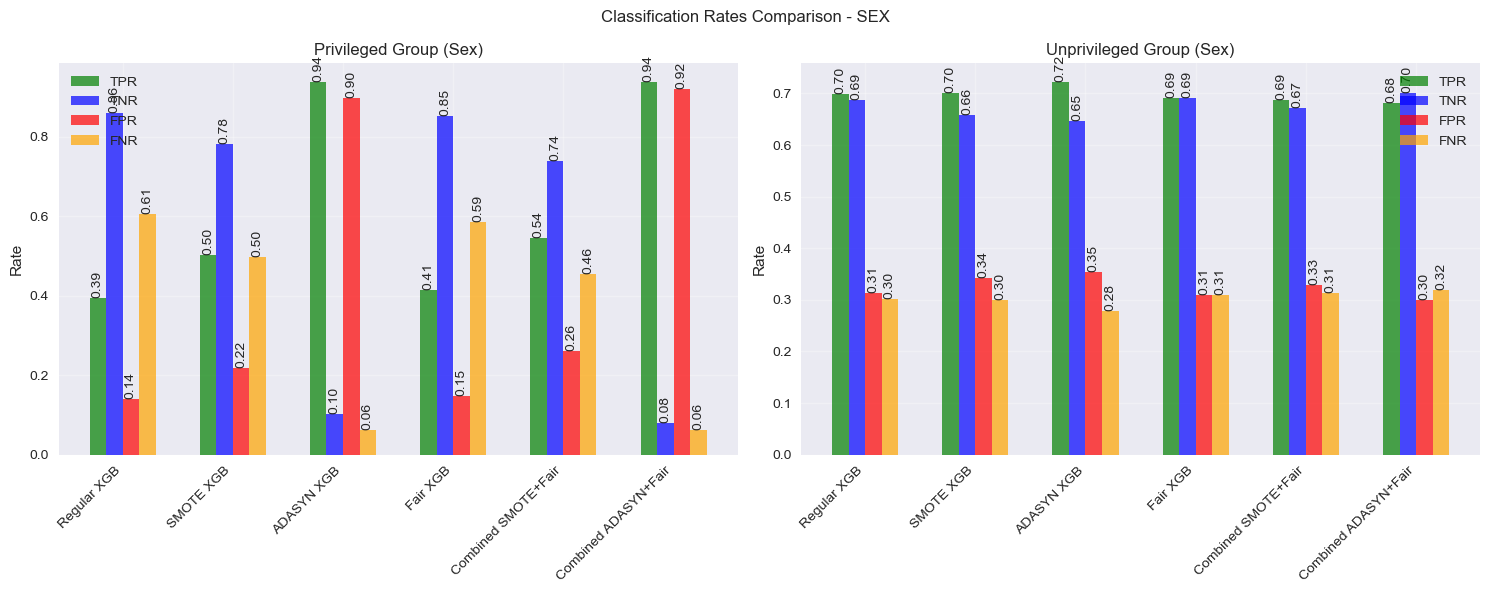

In [85]:
# Plot for Sex
plt.figure(figsize=(15, 6))
models_dict_sex = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB': smote_xgb_sex,
    'ADASYN XGB': adasyn_xgb_sex,
    'Fair XGB': fair_xgb_sex,
    'Combined SMOTE+Fair': combined_xgb_sex,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_sex
}

rates_privileged = []
rates_unprivileged = []
method_names = []

for method_name, model in models_dict_sex.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['sex']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['sex']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['sex']['unprivileged'],
        privileged_groups=protected_groups['sex']['privileged']
    )
    
    rates_privileged.append({
        'TPR': metrics.true_positive_rate(privileged=True),
        'TNR': metrics.true_negative_rate(privileged=True),
        'FPR': metrics.false_positive_rate(privileged=True),
        'FNR': metrics.false_negative_rate(privileged=True)
    })
    
    rates_unprivileged.append({
        'TPR': metrics.true_positive_rate(privileged=False),
        'TNR': metrics.true_negative_rate(privileged=False),
        'FPR': metrics.false_positive_rate(privileged=False),
        'FNR': metrics.false_negative_rate(privileged=False)
    })
    
    method_names.append(method_name)

df_privileged = pd.DataFrame(rates_privileged, index=method_names)
df_unprivileged = pd.DataFrame(rates_unprivileged, index=method_names)

width = 0.15
x = np.arange(len(method_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Privileged group plot
ax1.bar(x - 1.5*width, df_privileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax1.bar(x - 0.5*width, df_privileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax1.bar(x + 0.5*width, df_privileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax1.bar(x + 1.5*width, df_privileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax1.set_ylabel('Rate')
ax1.set_title('Privileged Group (Sex)')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_privileged[metric]):
        ax1.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

# Unprivileged group plot
ax2.bar(x - 1.5*width, df_unprivileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax2.bar(x - 0.5*width, df_unprivileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax2.bar(x + 0.5*width, df_unprivileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax2.bar(x + 1.5*width, df_unprivileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax2.set_ylabel('Rate')
ax2.set_title('Unprivileged Group (Sex)')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_unprivileged[metric]):
        ax2.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

plt.suptitle('Classification Rates Comparison - SEX')
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

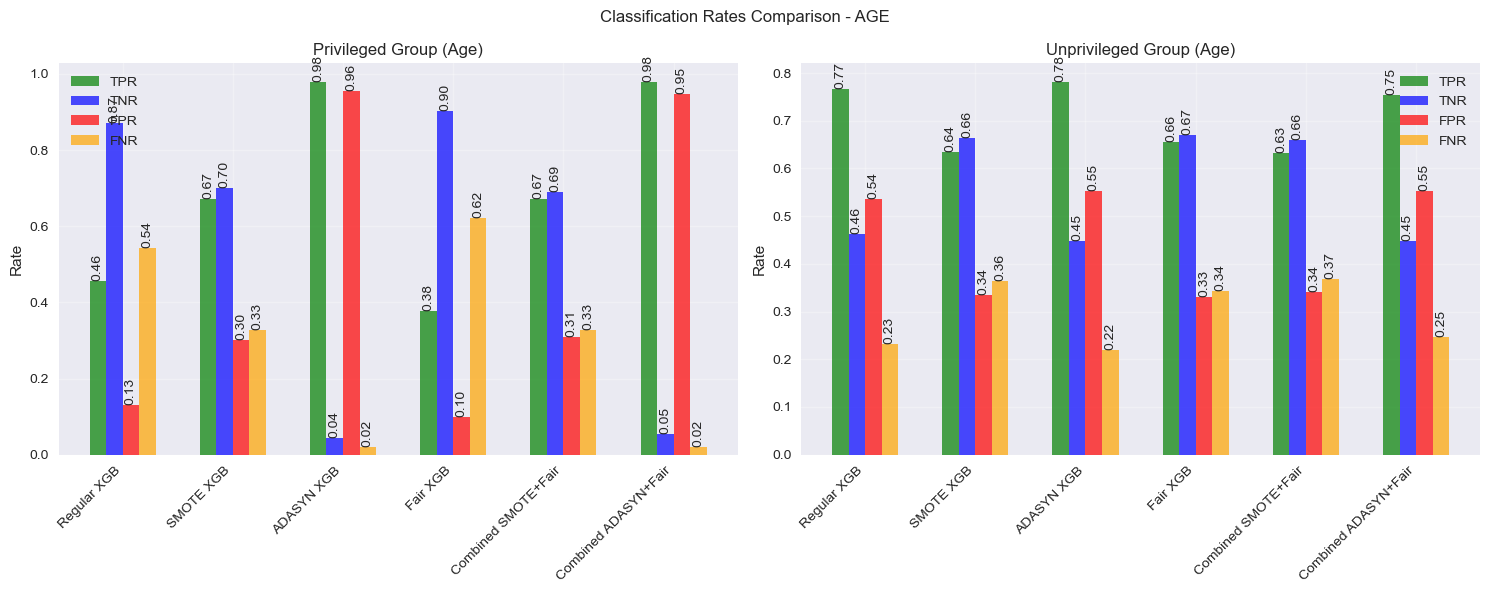

In [84]:
# Plot for Age
plt.figure(figsize=(15, 6))
models_dict_age = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB': smote_xgb_age,
    'ADASYN XGB': adasyn_xgb_age,
    'Fair XGB': fair_xgb_age,
    'Combined SMOTE+Fair': combined_xgb_age,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_age
}

rates_privileged = []
rates_unprivileged = []
method_names = []

for method_name, model in models_dict_age.items():
    y_pred = model.predict(X_test)
    
    test_df = X_test.copy()
    test_df['label'] = y_test
    pred_df = X_test.copy()
    pred_df['label'] = y_pred
    
    dataset_true = create_aif_dataset(test_df, 'label', protected_groups['age']['attributes'])
    dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups['age']['attributes'])
    
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=protected_groups['age']['unprivileged'],
        privileged_groups=protected_groups['age']['privileged']
    )
    
    rates_privileged.append({
        'TPR': metrics.true_positive_rate(privileged=True),
        'TNR': metrics.true_negative_rate(privileged=True),
        'FPR': metrics.false_positive_rate(privileged=True),
        'FNR': metrics.false_negative_rate(privileged=True)
    })
    
    rates_unprivileged.append({
        'TPR': metrics.true_positive_rate(privileged=False),
        'TNR': metrics.true_negative_rate(privileged=False),
        'FPR': metrics.false_positive_rate(privileged=False),
        'FNR': metrics.false_negative_rate(privileged=False)
    })
    
    method_names.append(method_name)

df_privileged = pd.DataFrame(rates_privileged, index=method_names)
df_unprivileged = pd.DataFrame(rates_unprivileged, index=method_names)

width = 0.15
x = np.arange(len(method_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Privileged group plot
ax1.bar(x - 1.5*width, df_privileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax1.bar(x - 0.5*width, df_privileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax1.bar(x + 0.5*width, df_privileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax1.bar(x + 1.5*width, df_privileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax1.set_ylabel('Rate')
ax1.set_title('Privileged Group (Age)')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_privileged[metric]):
        ax1.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

# Unprivileged group plot
ax2.bar(x - 1.5*width, df_unprivileged['TPR'], width, label='TPR', color='green', alpha=0.7)
ax2.bar(x - 0.5*width, df_unprivileged['TNR'], width, label='TNR', color='blue', alpha=0.7)
ax2.bar(x + 0.5*width, df_unprivileged['FPR'], width, label='FPR', color='red', alpha=0.7)
ax2.bar(x + 1.5*width, df_unprivileged['FNR'], width, label='FNR', color='orange', alpha=0.7)

ax2.set_ylabel('Rate')
ax2.set_title('Unprivileged Group (Age)')
ax2.set_xticks(x)
ax2.set_xticklabels(method_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for i, metric in enumerate(['TPR', 'TNR', 'FPR', 'FNR']):
    offset = (i - 1.5) * width
    for j, v in enumerate(df_unprivileged[metric]):
        ax2.text(j + offset, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

plt.suptitle('Classification Rates Comparison - AGE')
plt.tight_layout()
plt.show()

## Visualize disparate impact comparison

C:\Users\fsd_n\AppData\Local\Temp\ipykernel_1500\1682380106.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


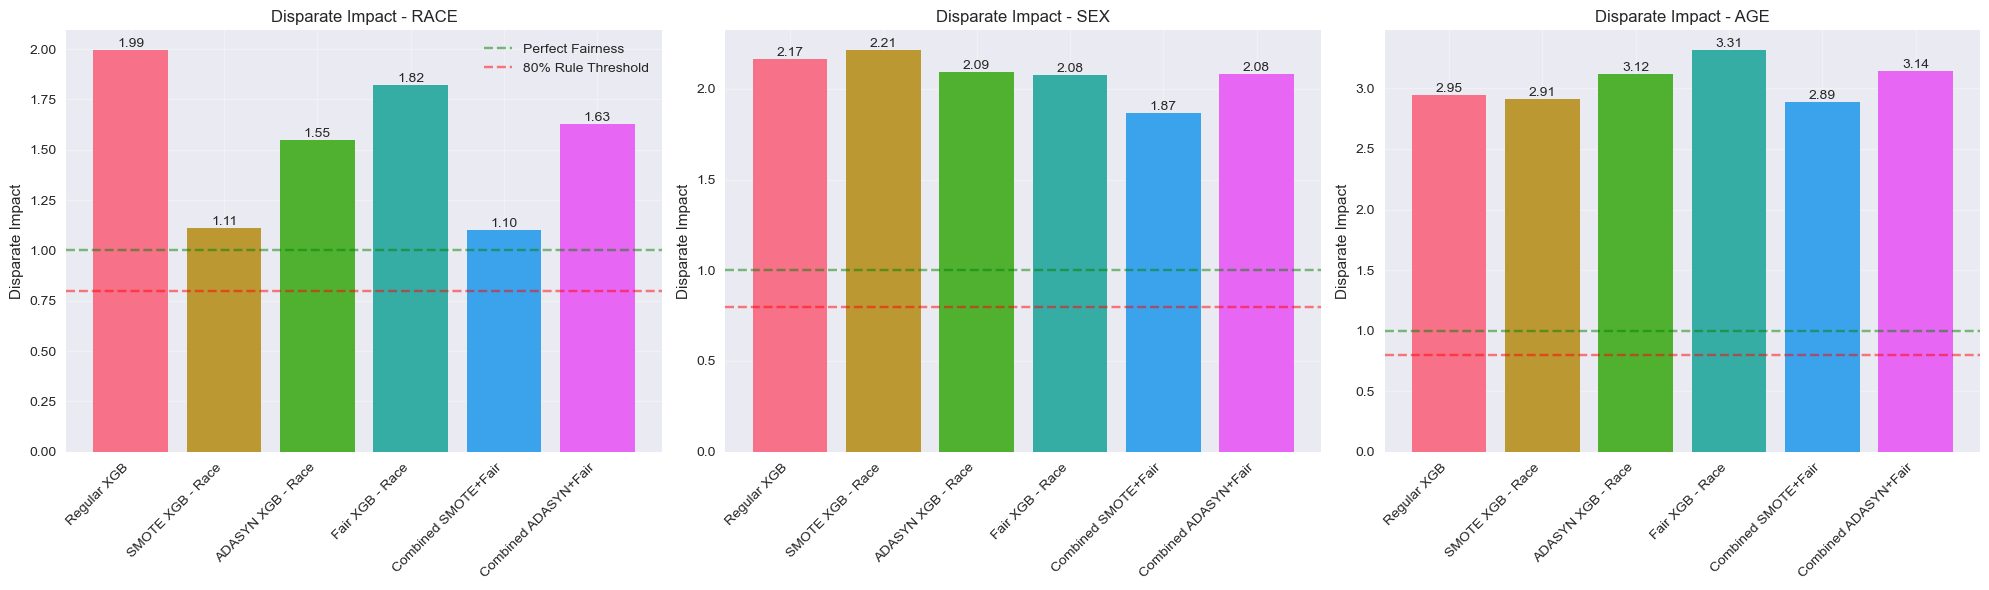

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disparate_impact_comparison(models_dict, X_test, y_test, protected_groups):
    """
    Plot disparate impact comparison for each protected attribute
    """
    # Set style
    plt.style.use('seaborn')
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Colors for different methods
    colors = sns.color_palette("husl", len(models_dict))
    
    # Protected attributes
    attrs = ['race', 'sex', 'age']
    
    # For each protected attribute
    for idx, attr in enumerate(attrs):
        disparate_impacts = []
        method_names = []
        
        # Calculate disparate impact for each model
        for method_name, model in models_dict.items():
            # Get predictions
            y_pred = model.predict(X_test)
            
            # Create datasets for fairness analysis
            test_df = X_test.copy()
            test_df['label'] = y_test
            pred_df = X_test.copy()
            pred_df['label'] = y_pred
            
            # Create AIF360 datasets
            dataset_true = create_aif_dataset(test_df, 'label', protected_groups[attr]['attributes'])
            dataset_pred = create_aif_dataset(pred_df, 'label', protected_groups[attr]['attributes'])
            
            # Calculate metrics
            metrics = ClassificationMetric(
                dataset_true,
                dataset_pred,
                unprivileged_groups=protected_groups[attr]['unprivileged'],
                privileged_groups=protected_groups[attr]['privileged']
            )
            
            disparate_impacts.append(metrics.disparate_impact())
            method_names.append(method_name)
        
        # Create bar plot
        bars = axes[idx].bar(range(len(method_names)), disparate_impacts, color=colors)
        
        # Add reference lines
        axes[idx].axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Fairness')
        axes[idx].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='80% Rule Threshold')
        
        # Customize plot
        axes[idx].set_xticks(range(len(method_names)))
        axes[idx].set_xticklabels(method_names, rotation=45, ha='right')
        axes[idx].set_title(f'Disparate Impact - {attr.upper()}')
        axes[idx].set_ylabel('Disparate Impact')
        axes[idx].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.2f}',
                         ha='center', va='bottom')
    
    # Add legend to the first subplot
    axes[0].legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Create dictionary of models
models_dict = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB - Race': smote_xgb_race,
    'ADASYN XGB - Race': adasyn_xgb_race,
    'Fair XGB - Race': fair_xgb_race,
    'Combined SMOTE+Fair': combined_xgb_race,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_race
}

# Create the plots
plot_disparate_impact_comparison(models_dict, X_test, y_test, protected_groups)

C:\Users\fsd_n\AppData\Local\Temp\ipykernel_1500\1682380106.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


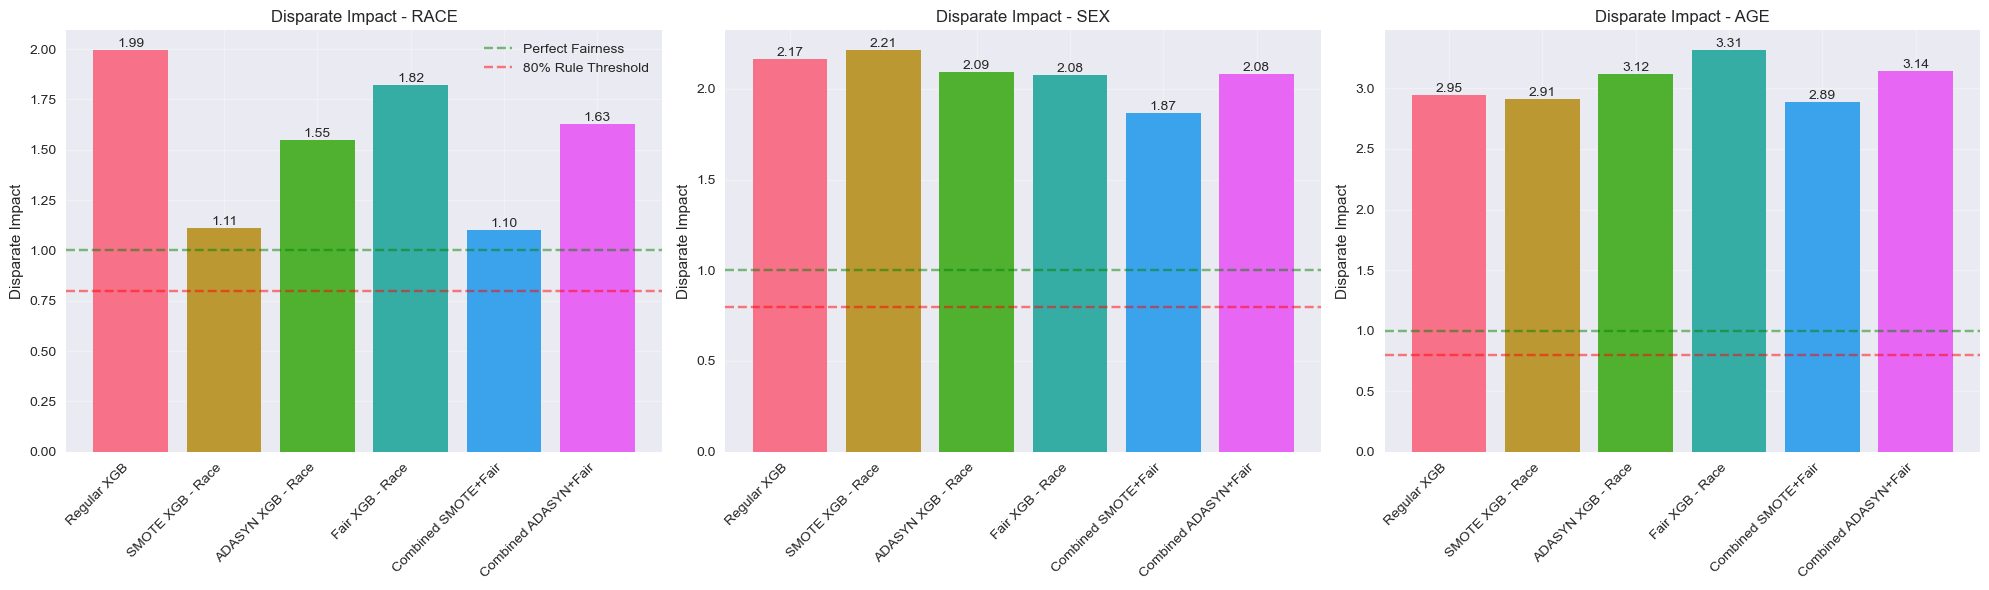

In [74]:
# For race-specific comparison
models_dict_race = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB - Race': smote_xgb_race,
    'ADASYN XGB - Race': adasyn_xgb_race,
    'Fair XGB - Race': fair_xgb_race,
    'Combined SMOTE+Fair': combined_xgb_race,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_race
}

plot_disparate_impact_comparison(models_dict_race, X_test, y_test, protected_groups)


C:\Users\fsd_n\AppData\Local\Temp\ipykernel_1500\1682380106.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


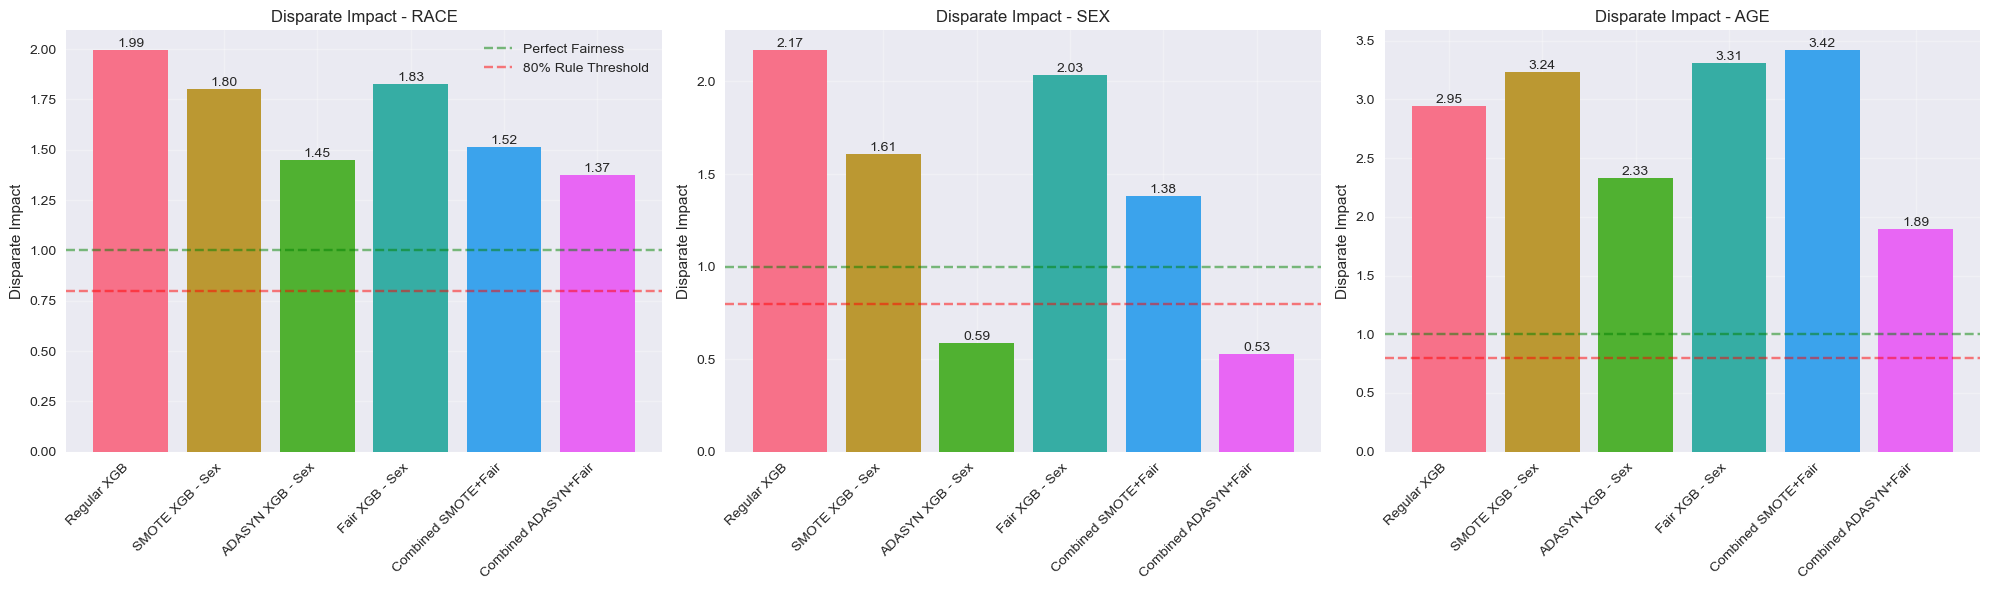

In [75]:

# For sex-specific comparison
models_dict_sex = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB - Sex': smote_xgb_sex,
    'ADASYN XGB - Sex': adasyn_xgb_sex,
    'Fair XGB - Sex': fair_xgb_sex,
    'Combined SMOTE+Fair': combined_xgb_sex,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_sex
}

plot_disparate_impact_comparison(models_dict_sex, X_test, y_test, protected_groups)

C:\Users\fsd_n\AppData\Local\Temp\ipykernel_1500\1682380106.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


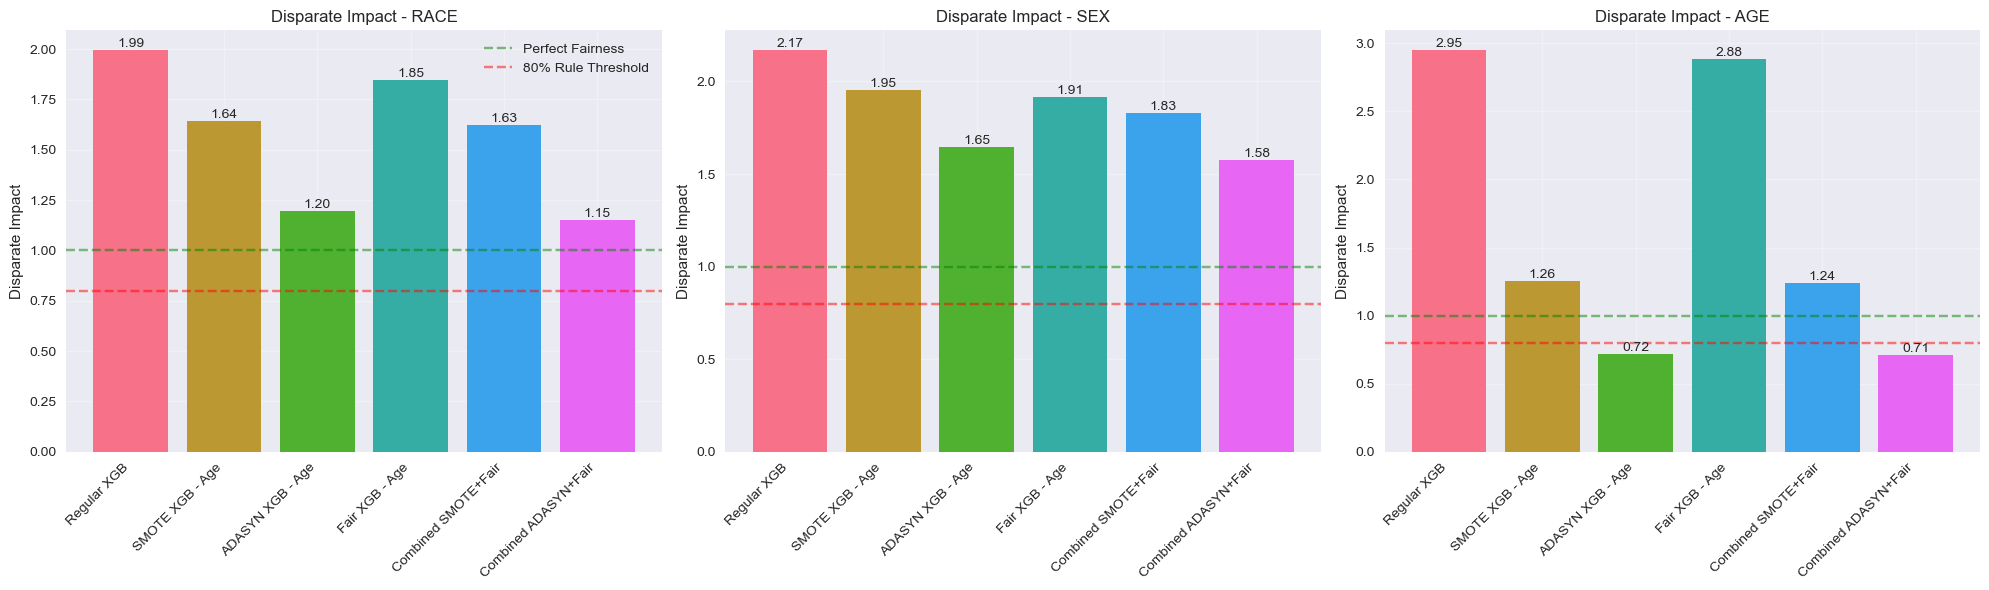

In [76]:
# For age-specific comparison
models_dict_age = {
    'Regular XGB': regular_xgb,
    'SMOTE XGB - Age': smote_xgb_age,
    'ADASYN XGB - Age': adasyn_xgb_age,
    'Fair XGB - Age': fair_xgb_age,
    'Combined SMOTE+Fair': combined_xgb_age,
    'Combined ADASYN+Fair': combined_adasyn_fair_xgb_age
}

plot_disparate_impact_comparison(models_dict_age, X_test, y_test, protected_groups)
